In [4]:
from astropy.table import Table
import numpy as np
import pylab as plt
from astropy.table import vstack

In [2]:
def FitsRead(time):
    # Read the fits file for that time and return table of stars
    if time < 10:
        time = '00{0}'.format(time)
    elif time < 100:
        time = '0{0}'.format(time)
    try:
        fileName = 'coords.starsandgas.chemrun733DiffFB10T1.0.0{0}0.fits'.format(time)
        read = Table.read(fileName,1)
        stars = (read['P']=='s')
        cat = read[stars]
    except:
        try:
            fileName = 'coords.chem733DiffFB10T1.0.0{0}0.fits'.format(time)
            cat = Table.read(fileName,1)
        except:
            raise ValueError('No file')
    return cat

In [3]:
txy = Table.read('clumps5.fits',1)
txy.add_column(Table.Column(np.zeros(len(txy))+2),name='ID')
for i in range(0,len(txy)):
    if txy['CLUMPID'][i]==1:
        txy['ID'][i] = 1
stars = Table.read('clumps5.fits',2)
merges = Table.read('clumps5.fits',3)
merges.reverse()
txyz = Table.read('txyzform.fits',1)
for merge in merges:
    for i in txy:
        if i['CLUMPID']==merge['CLUMP1']:
            id1 = i['ID']
            break
    for i in range(0,len(txy)):
        if txy['CLUMPID'][i]==merge['CLUMP2']:
            txy['ID'][i] = id1+1
        elif txy['ID'][i]>id1:
            txy['ID'][i] = txy['ID'][i]+1
idmax = np.max(txy['ID'])
for i in range(0,len(txy)):
    if txy['ID'][i]==idmax:
        txy['ID'][i] = txy['ID'][i]+txy['CLUMPID'][i]
idlist = np.unique(np.array(txy['ID']))
for i in range(0,len(idlist)):
    for j in range(0,len(txy)):
        if txy['ID'][j]==idlist[i]:
            txy['ID'][j] = i+1
idlist = np.unique(np.array(txy['ID']))
for i in range(0,len(merges)):
    for j in range(2,len(merges[i])):
        if merges[i][j]!=0:
            inclump = txy[(txy['CLUMPID']==merges[i][j])]
            merges[i][j] = inclump['ID'][0]

txy.add_column(Table.Column(np.zeros(len(txy))),name='Z')
txy.add_column(Table.Column(np.zeros(len(txy))),name='MASS')
txy.add_column(Table.Column(np.zeros(len(txy))),name='MEANFEH')
txy.add_column(Table.Column(np.zeros(len(txy))),name='MEANOFE')
ages = []
for clumpid in np.unique(np.array(txy['CLUMPID'])):
    txyclump = txy[(txy['CLUMPID']==clumpid)]
    starsclump = stars[(stars['CLUMPID']==clumpid)]
    starttime = int(txyclump['TIME'][0]*10)+1
    endtime = int(txyclump['TIME'][-1]*10)+2
    for i in txyclump:
        ages.append(i['TIME']-txyclump['TIME'][0])
    for time in range(starttime,endtime):
        snapshot = FitsRead(time)
        cutstars = starsclump[(starsclump['INDEX']<len(snapshot))]
        clumpstars = snapshot[cutstars['INDEX']]
        x = clumpstars['X']
        y = clumpstars['Y']
        tform = txyz[cutstars['INDEX']]
        """try:
            current = txyclump[(txyclump['TIME'] == time/10)]
            clumpx = current['X']
            clumpy = current['Y']
            radius = 3*np.sqrt((sum((x-clumpx)**2)+sum((y-clumpy)**2))/len(x))
        except:
            clumpx = np.mean(x)
            clumpy = np.mean(y)
            radius = 3*np.sqrt((sum((x-clumpx)**2)+sum((y-clumpy)**2))/len(x))
        bound = clumpstars[((clumpstars['X']-clumpx)**2+(clumpstars['Y']-clumpy)**2<radius**2)]
        mass = sum(bound['MS'])*2.33*10**5"""
        for i in range(0,len(txy)):
            if txy['CLUMPID'][i]==clumpid:
                if int(round(txy['TIME'][i]*10+0.05,2))+1==time:
                    formed = clumpstars[(tform['TFORM']>txy['TIME'][i])]
                    tform2 = tform[(tform['TFORM']>txy['TIME'][i])]
                    newstars = formed[(tform2['TFORM']<txy['TIME'][i]+0.005)]
                    tform3 = tform2[(tform2['TFORM']<txy['TIME'][i]+0.005)]
                    if len(newstars)==0:
                        meanfeh = None
                        meanofe = None
                        z = None
                    else:
                        meanfeh = np.mean(newstars['FEH'])
                        meanofe = np.mean(newstars['OFE'])
                        z = np.mean(tform3['ZFORM'])
                    txy['MEANFEH'][i] = meanfeh
                    txy['MEANOFE'][i] = meanofe
                    txy['Z'][i] = z
                elif txy['TIME'][i]>=3.995:
                    newstars = clumpstars[(tform['TFORM']>txy['TIME'][i])]
                    if len(newstars)==0:
                        meanfeh = None
                        meanofe = None
                    else:
                        meanfeh = np.mean(newstars['FEH'])
                        meanofe = np.mean(newstars['OFE'])
                    txy['MEANFEH'][i] = meanfeh
                    txy['MEANOFE'][i] = meanofe
                if int(txy['TIME'][i]*10)+1==time:
                    formed = clumpstars[(tform['TFORM']<txy['TIME'][i])]
                    mass = sum(formed['MS'])*2.33*10**5
                    txy['MASS'][i] = mass
txy.add_column(Table.Column(ages),name='AGE')

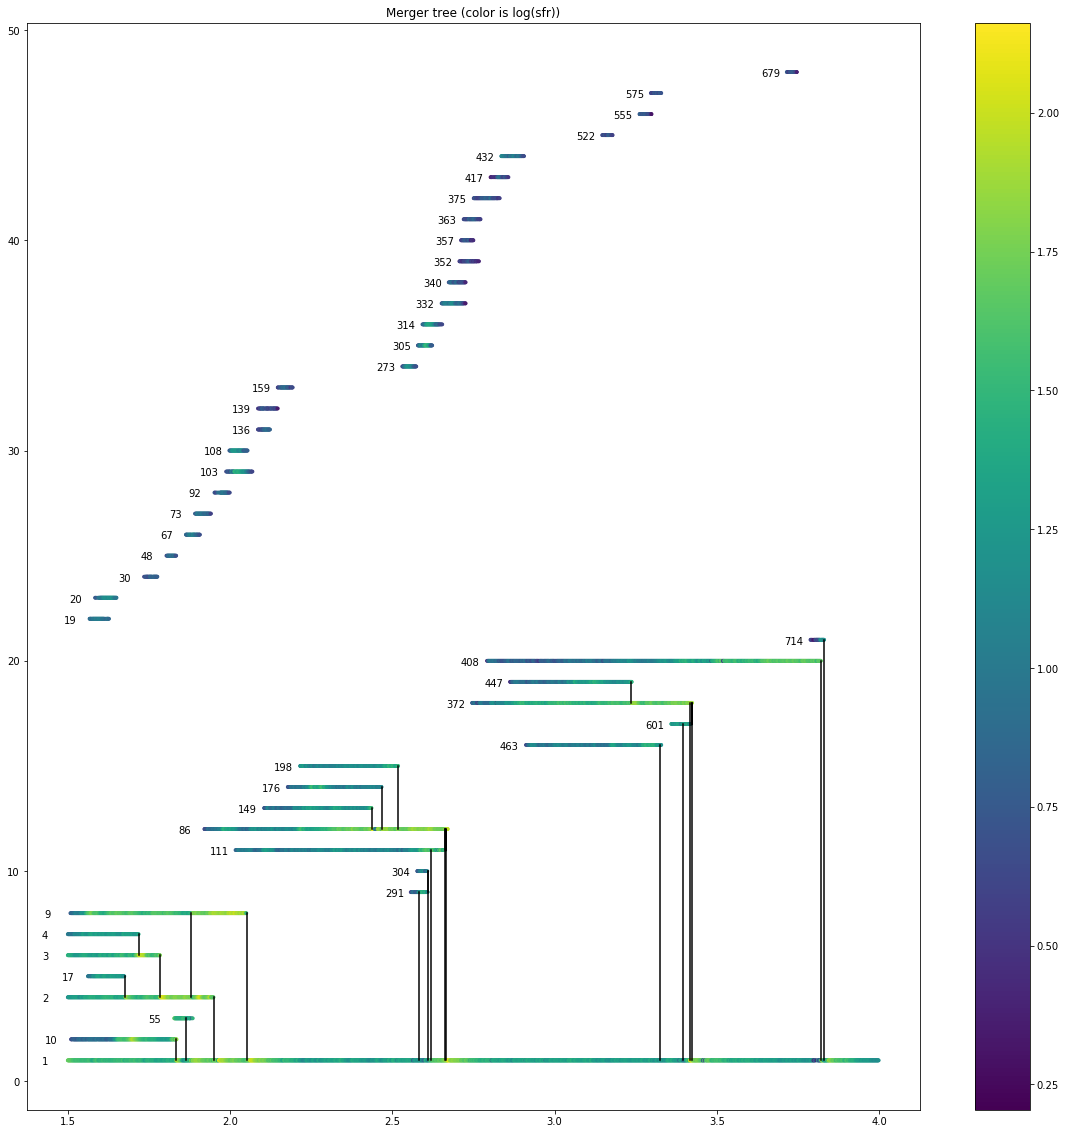

In [28]:
plt.figure(figsize=(20,20))
for i in idlist:
    clump = txy[(txy['ID']==i)]
    plt.text(clump['TIME'][0]-0.08,clump['ID'][0]-0.2,str(clump['CLUMPID'][0]))
plt.scatter(txy['TIME'],txy['ID'],c=np.log10(txy['NSTARS']/5),s=8)
plt.colorbar()
for merge in merges:
    merge = list(merge)
    ids = merge[2:2+merge[1]]
    t = [merge[0]]*merge[1]
    plt.plot(t,ids,c='k')
    plt.title('Merger tree (color is log(sfr))')

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


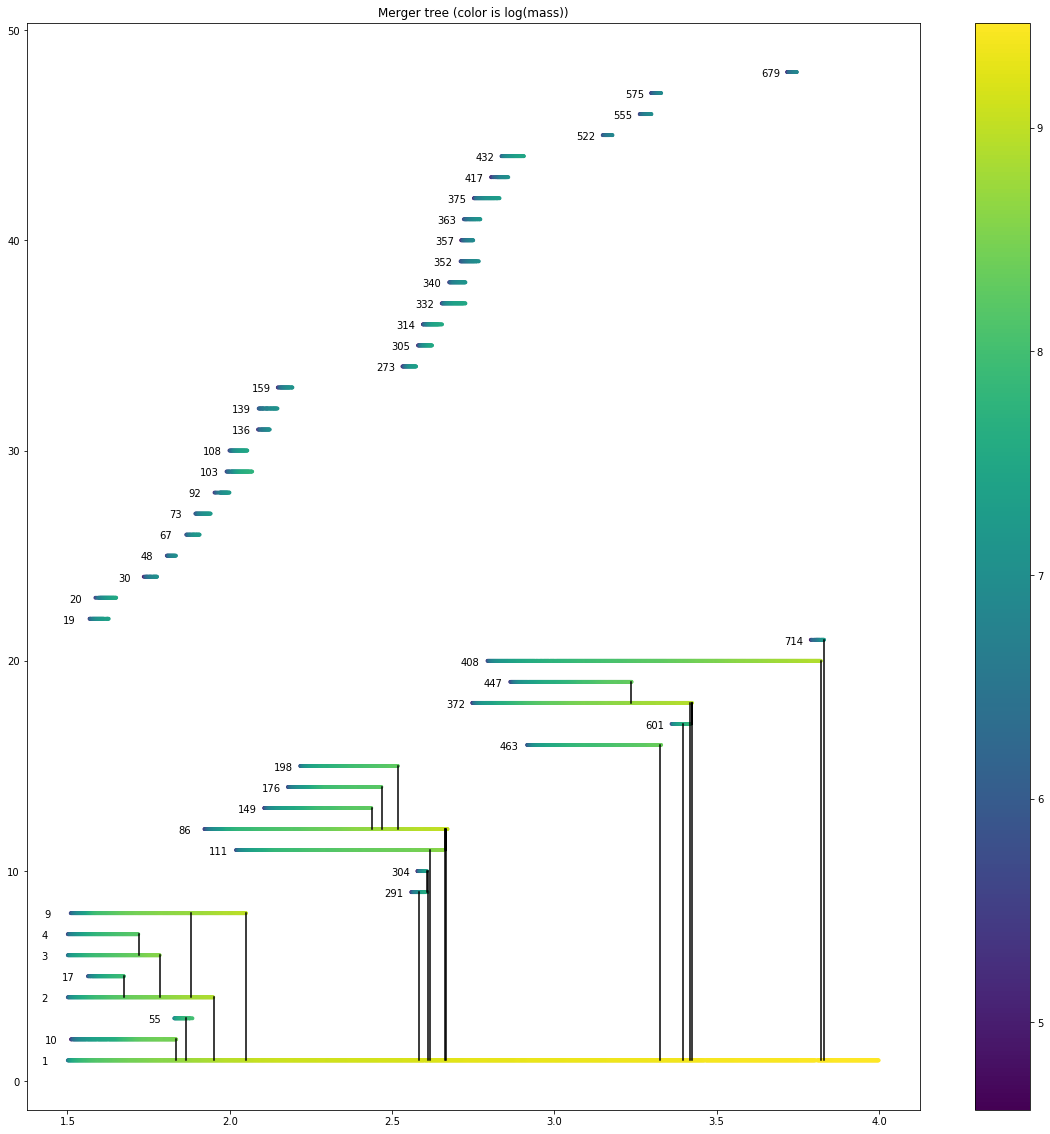

In [30]:
plt.figure(figsize=(20,20))
for i in idlist:
    clump = txy[(txy['ID']==i)]
    plt.text(clump['TIME'][0]-0.08,clump['ID'][0]-0.2,str(clump['CLUMPID'][0]))
plt.scatter(txy['TIME'],txy['ID'],c=np.log10(txy['MASS']),s=8)
plt.colorbar()
for merge in merges:
    merge = list(merge)
    ids = merge[2:2+merge[1]]
    t = [merge[0]]*merge[1]
    plt.plot(t,ids,c='k')
    plt.title('Merger tree (color is log(mass))')

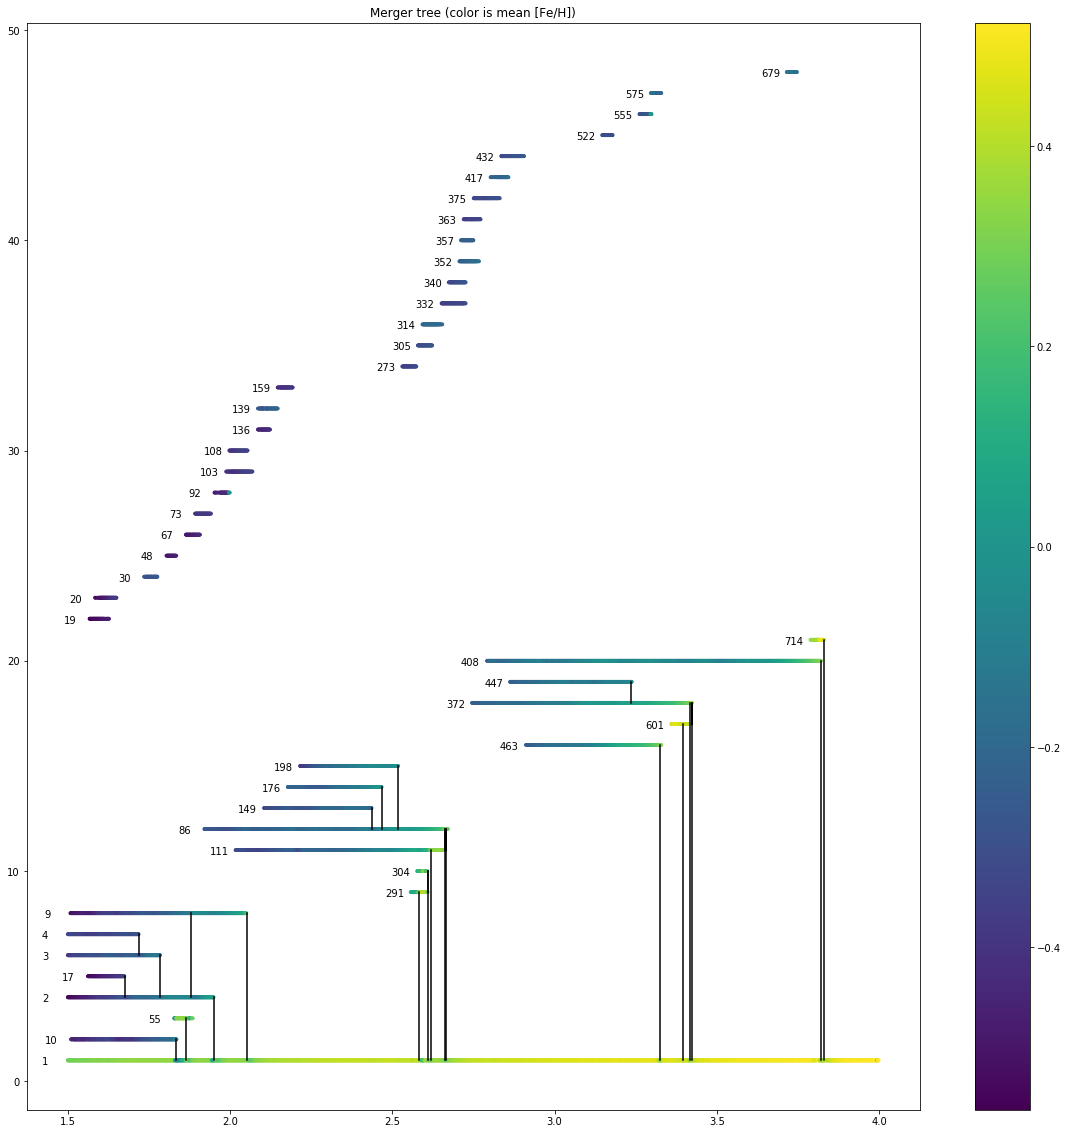

In [6]:
plt.figure(figsize=(20,20))
for i in idlist:
    clump = txy[(txy['ID']==i)]
    plt.text(clump['TIME'][0]-0.08,clump['ID'][0]-0.2,str(clump['CLUMPID'][0]))
plt.scatter(txy['TIME'],txy['ID'],c=txy['MEANFEH'],s=8)
plt.colorbar()
for merge in merges:
    merge = list(merge)
    ids = merge[2:2+merge[1]]
    t = [merge[0]]*merge[1]
    plt.plot(t,ids,c='k')
    plt.title('Merger tree (color is mean [Fe/H])')

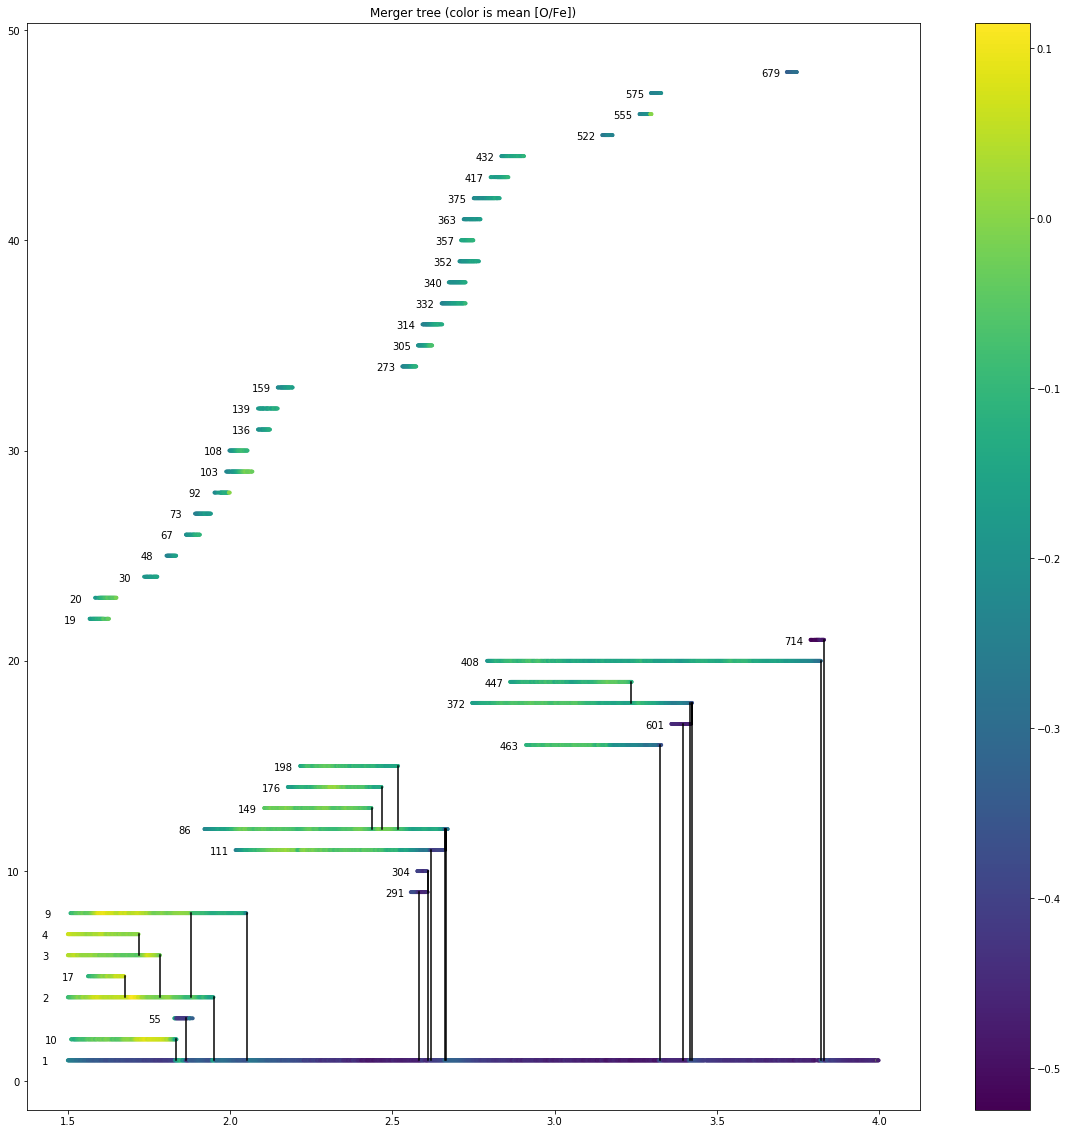

In [7]:
plt.figure(figsize=(20,20))
for i in idlist:
    clump = txy[(txy['ID']==i)]
    plt.text(clump['TIME'][0]-0.08,clump['ID'][0]-0.2,str(clump['CLUMPID'][0]))
plt.scatter(txy['TIME'],txy['ID'],c=txy['MEANOFE'],s=8)
plt.colorbar()
for merge in merges:
    merge = list(merge)
    ids = merge[2:2+merge[1]]
    t = [merge[0]]*merge[1]
    plt.plot(t,ids,c='k')
    plt.title('Merger tree (color is mean [O/Fe])')

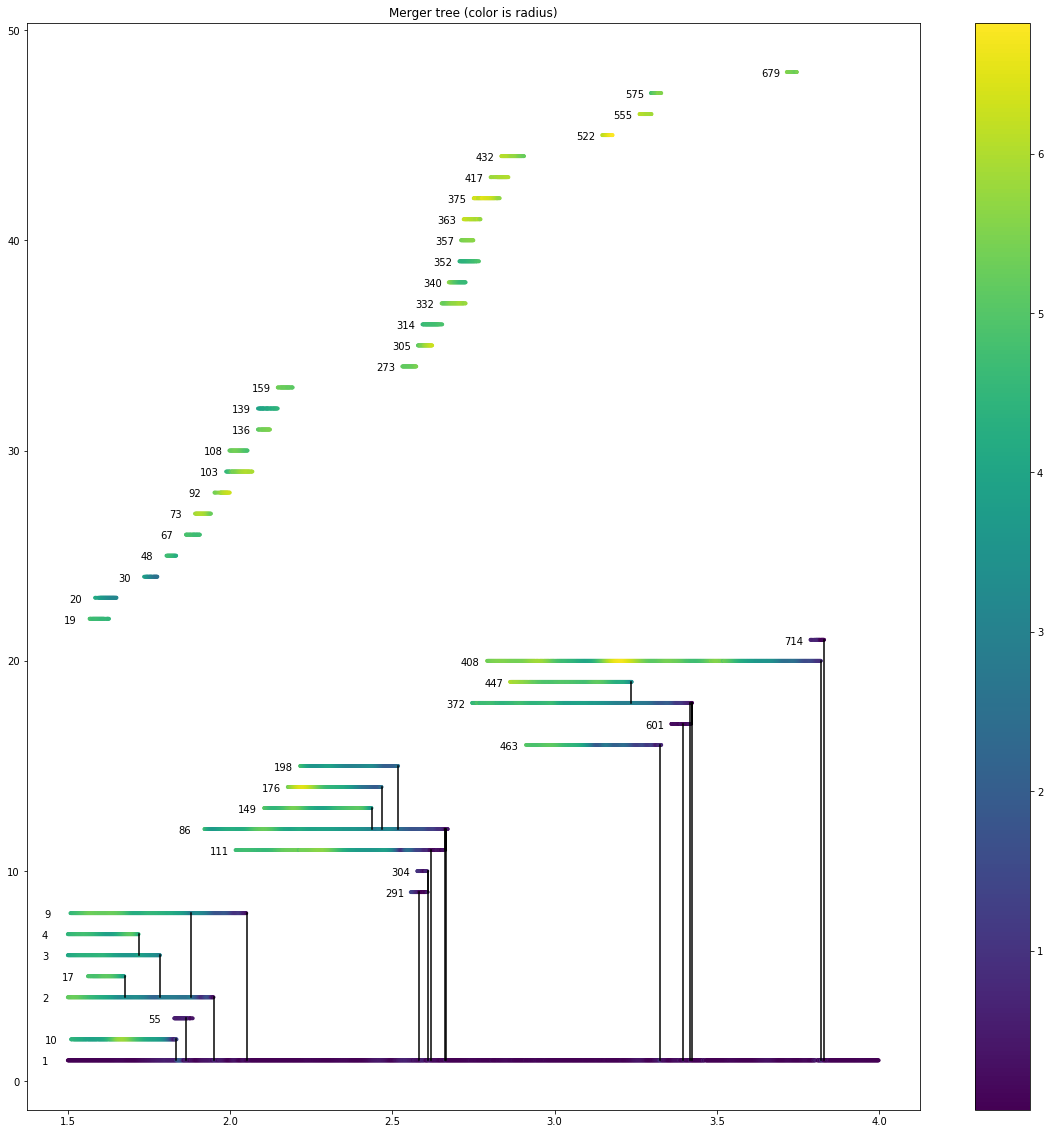

In [6]:
plt.figure(figsize=(20,20))
for i in idlist:
    clump = txy[(txy['ID']==i)]
    plt.text(clump['TIME'][0]-0.08,clump['ID'][0]-0.2,str(clump['CLUMPID'][0]))
plt.scatter(txy['TIME'],txy['ID'],c=(txy['X']**2+txy['Y']**2)**(1/2),s=8)
plt.colorbar()
for merge in merges:
    merge = list(merge)
    ids = merge[2:2+merge[1]]
    t = [merge[0]]*merge[1]
    plt.plot(t,ids,c='k')
    plt.title('Merger tree (color is radius)')

(-0.04, 0.04)

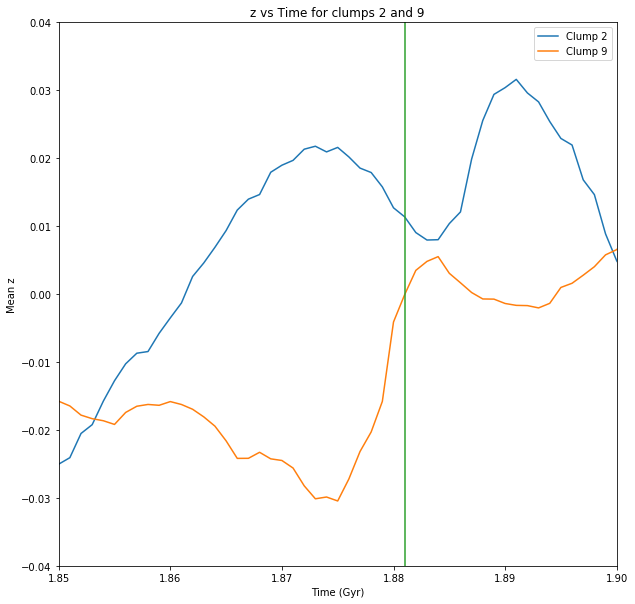

In [18]:
clump2 = txy[(txy['CLUMPID']==2)]
clump9 = txy[(txy['CLUMPID']==9)]
plt.figure(figsize=(10,10))
clumps = vstack([clump2,clump9])
#plt.scatter(clumps['TIME'],clumps['Z'],c=(clumps['X']**2+clumps['Y']**2)**(1/2),s=3)
plt.plot(clump2['TIME'],clump2['Z'],label='Clump 2')
plt.plot(clump9['TIME'],clump9['Z'],label='Clump 9')
plt.legend()
plt.xlabel('Time (Gyr)')
plt.ylabel('Mean z')
plt.title('z vs Time for clumps 2 and 9')
#plt.colorbar()
merges2 = Table.read('clumps5.fits',3)
merge2 = merges2[(merges2['CLUMP1']==2)]
merge29 = merge2[(merge2['CLUMP2']==9)]
plt.plot([merge29['TIME'][0],merge29['TIME'][0]],[-0.1,0.05])
plt.xlim(1.85,1.9)
plt.ylim(-0.04,0.04)

Text(0.5,1,'Mean [Fe/H] vs Time (color is radius)')

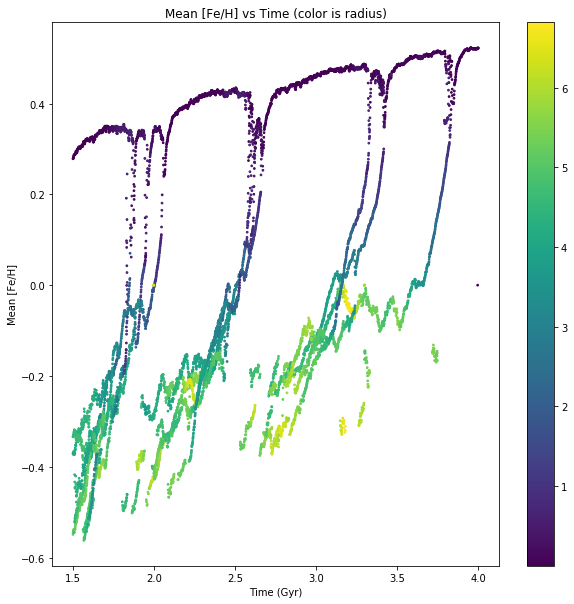

In [8]:
plt.figure(figsize=(10,10))
plt.scatter(txy['TIME'],txy['MEANFEH'],c=(txy['X']**2+txy['Y']**2)**(1/2),s=3)
plt.colorbar()
plt.xlabel('Time (Gyr)')
plt.ylabel('Mean [Fe/H]')
plt.title('Mean [Fe/H] vs Time (color is radius)')

Text(0.5,1,'Mean [O/Fe] vs Time (color is radius)')

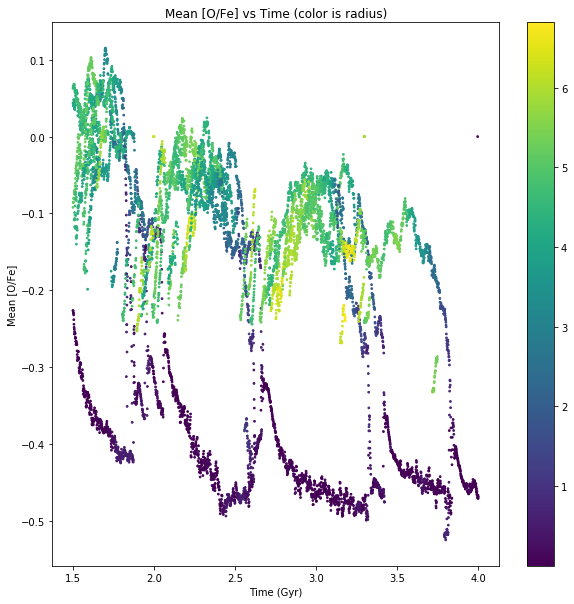

In [9]:
plt.figure(figsize=(10,10))
plt.scatter(txy['TIME'],txy['MEANOFE'],c=(txy['X']**2+txy['Y']**2)**(1/2),s=3)
plt.colorbar()
plt.xlabel('Time (Gyr)')
plt.ylabel('Mean [O/Fe]')
plt.title('Mean [O/Fe] vs Time (color is radius)')

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5,1,'Mean [Fe/H] vs Time (color is log(mass))')

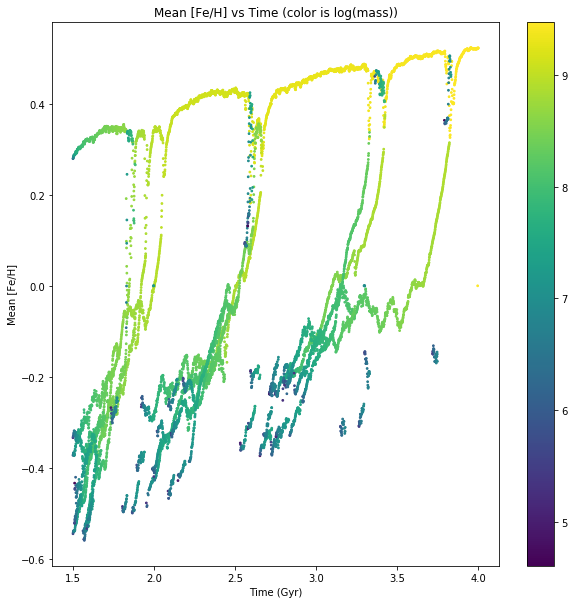

In [29]:
plt.figure(figsize=(10,10))
plt.scatter(txy['TIME'],txy['MEANFEH'],c=np.log10(txy['MASS']),s=3)
plt.colorbar()
plt.xlabel('Time (Gyr)')
plt.ylabel('Mean [Fe/H]')
plt.title('Mean [Fe/H] vs Time (color is log(mass))')

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5,1,'Mean [O/Fe] vs Time (color is log(mass))')

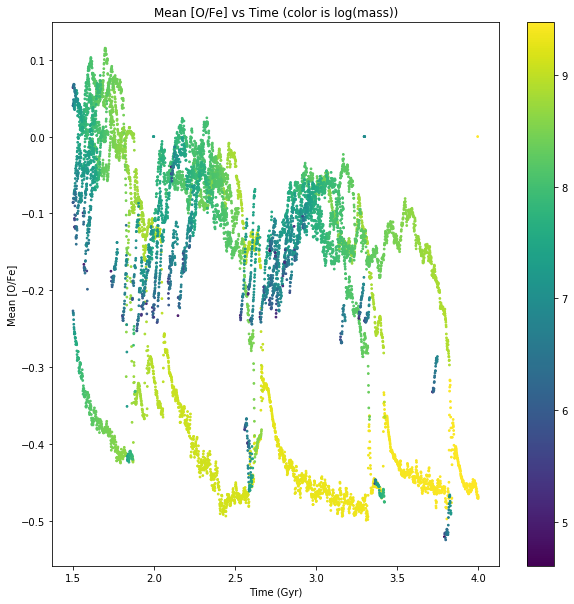

In [31]:
plt.figure(figsize=(10,10))
plt.scatter(txy['TIME'],txy['MEANOFE'],c=np.log10(txy['MASS']),s=3)
plt.colorbar()
plt.xlabel('Time (Gyr)')
plt.ylabel('Mean [O/Fe]')
plt.title('Mean [O/Fe] vs Time (color is log(mass))')

Text(0.5,1,'Mean [Fe/H] vs Radius (color is time)')

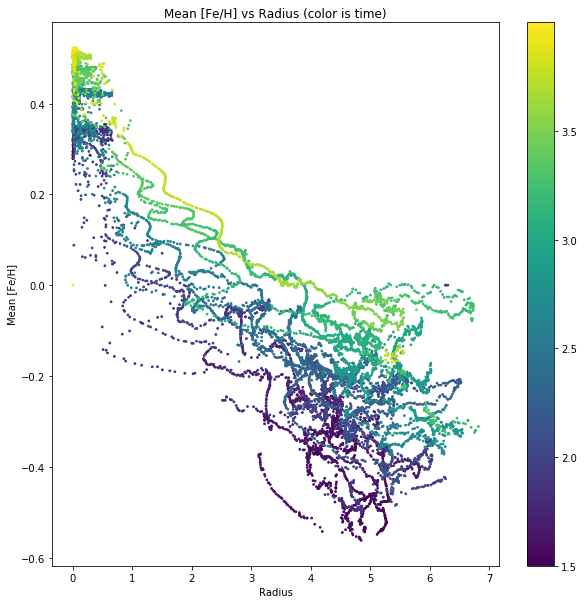

In [12]:
plt.figure(figsize=(10,10))
plt.scatter((txy['X']**2+txy['Y']**2)**(1/2),txy['MEANFEH'],c=txy['TIME'],s=3)
plt.colorbar()
plt.xlabel('Radius')
plt.ylabel('Mean [Fe/H]')
plt.title('Mean [Fe/H] vs Radius (color is time)')

Text(0.5,1,'Mean [O/Fe] vs Radius (color is time)')

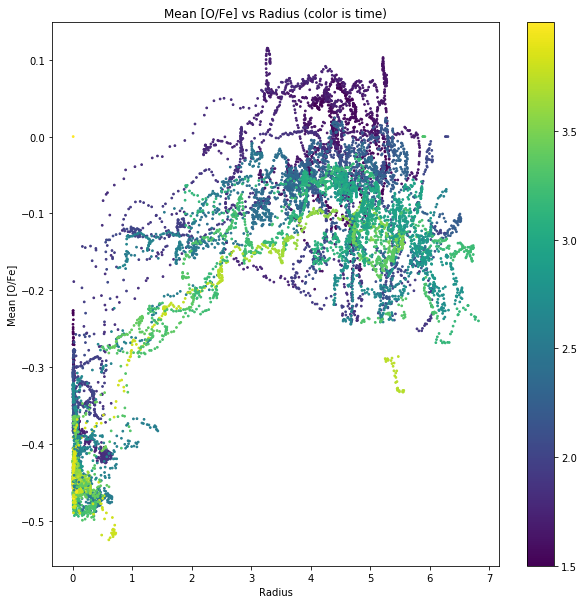

In [13]:
plt.figure(figsize=(10,10))
plt.scatter((txy['X']**2+txy['Y']**2)**(1/2),txy['MEANOFE'],c=txy['TIME'],s=3)
plt.colorbar()
plt.xlabel('Radius')
plt.ylabel('Mean [O/Fe]')
plt.title('Mean [O/Fe] vs Radius (color is time)')

Text(0.5,1,'Mean [O/Fe] vs Mean [Fe/H] (color is radius)')

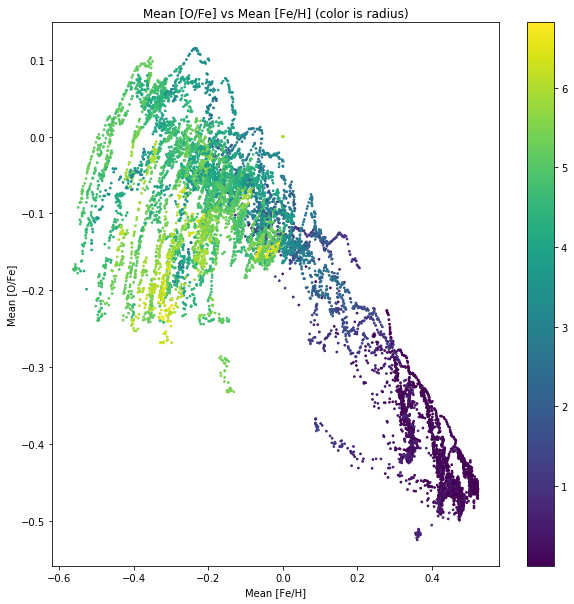

In [14]:
plt.figure(figsize=(10,10))
plt.scatter(txy['MEANFEH'],txy['MEANOFE'],c=(txy['X']**2+txy['Y']**2)**(1/2),s=3)
plt.colorbar()
plt.xlabel('Mean [Fe/H]')
plt.ylabel('Mean [O/Fe]')
plt.title('Mean [O/Fe] vs Mean [Fe/H] (color is radius)')

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5,1,'Mean [O/Fe] vs Mean [Fe/H] (color is log clump age)')

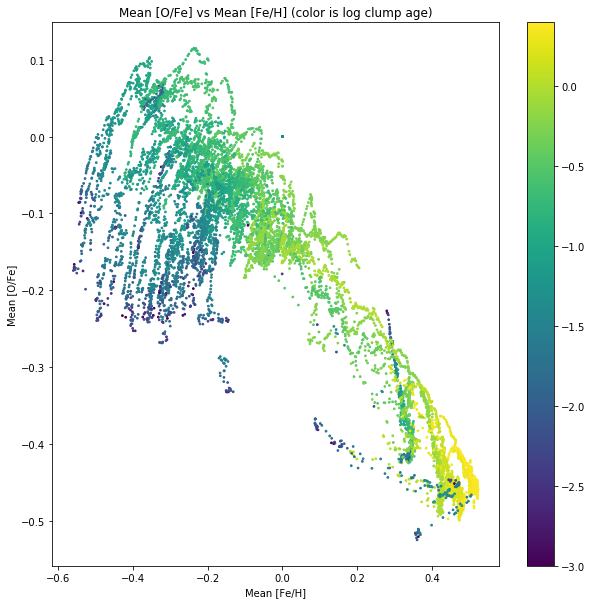

In [32]:
plt.figure(figsize=(10,10))
plt.scatter(txy['MEANFEH'],txy['MEANOFE'],c=np.log10(txy['AGE']),s=3)
plt.colorbar()
plt.xlabel('Mean [Fe/H]')
plt.ylabel('Mean [O/Fe]')
plt.title('Mean [O/Fe] vs Mean [Fe/H] (color is log clump age)')

Text(0.5,1,'Mean [O/Fe] vs Time')

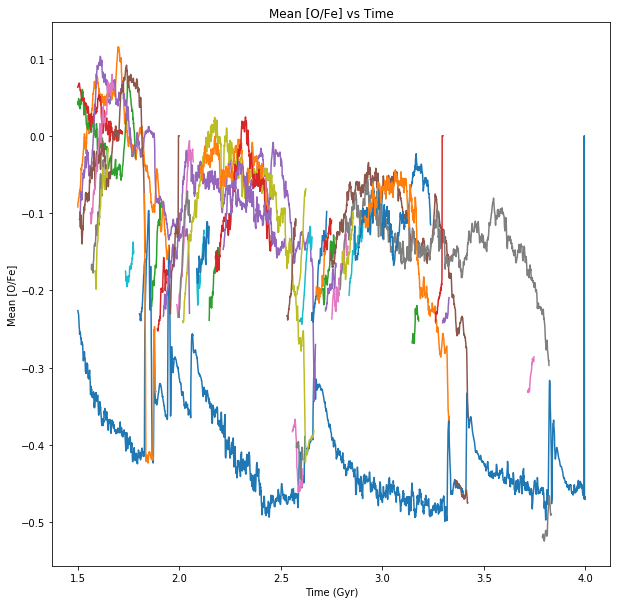

In [16]:
plt.figure(figsize=(10,10))
for clumpid in np.unique(np.array(txy['CLUMPID'])):
    txyclump = txy[(txy['CLUMPID']==clumpid)]
    plt.plot(txyclump['TIME'],txyclump['MEANOFE'])
plt.xlabel('Time (Gyr)')
plt.ylabel('Mean [O/Fe]')
plt.title('Mean [O/Fe] vs Time')

C:\Users\betha\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


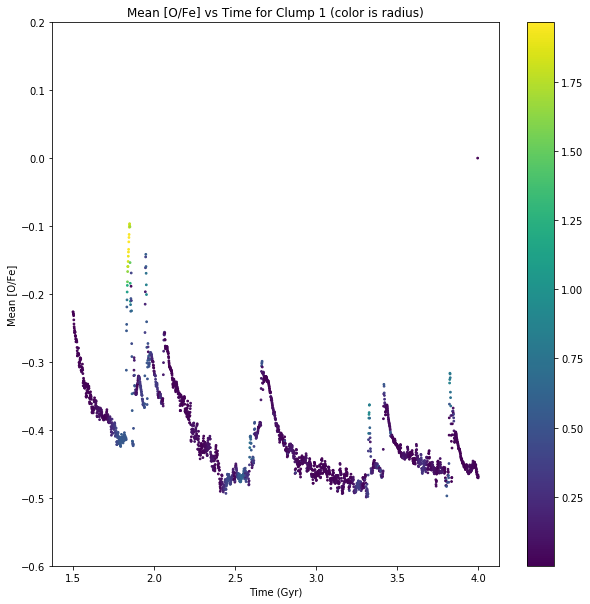

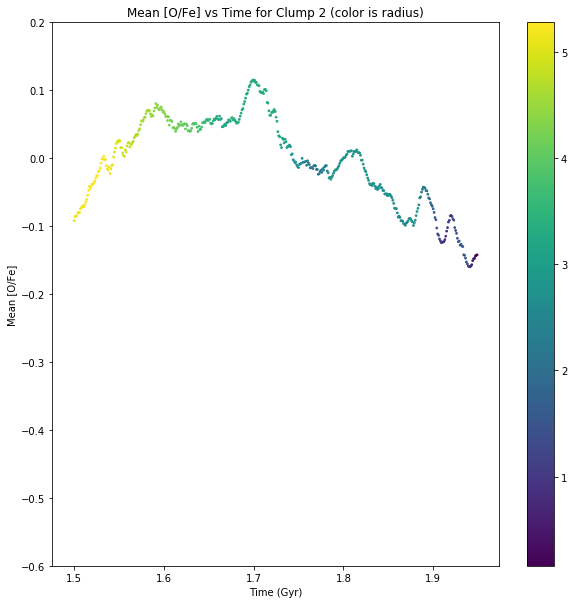

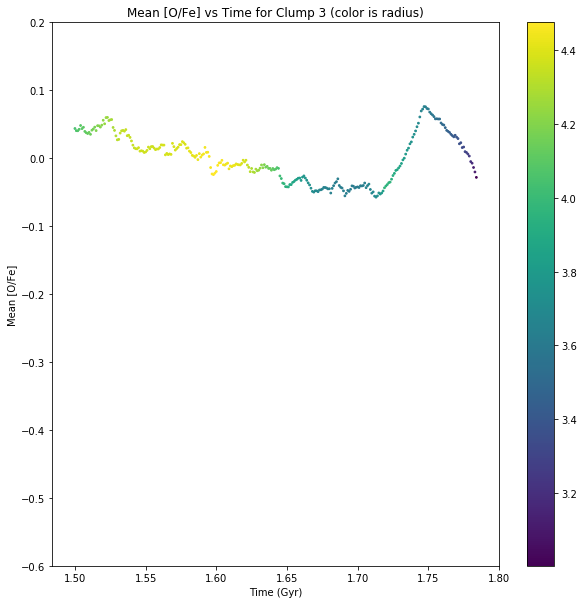

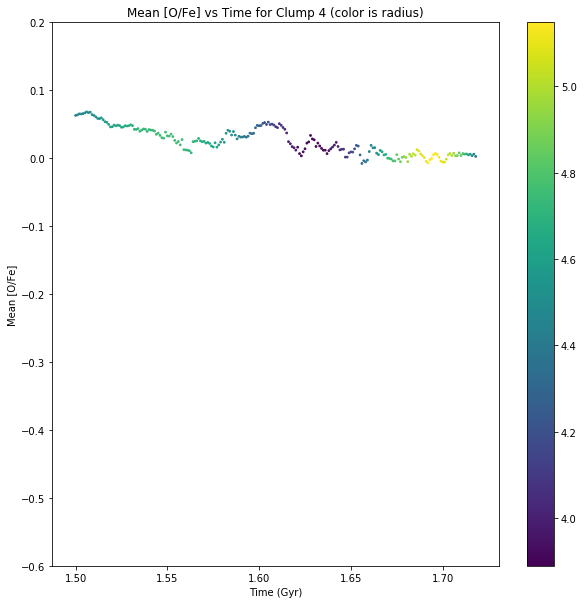

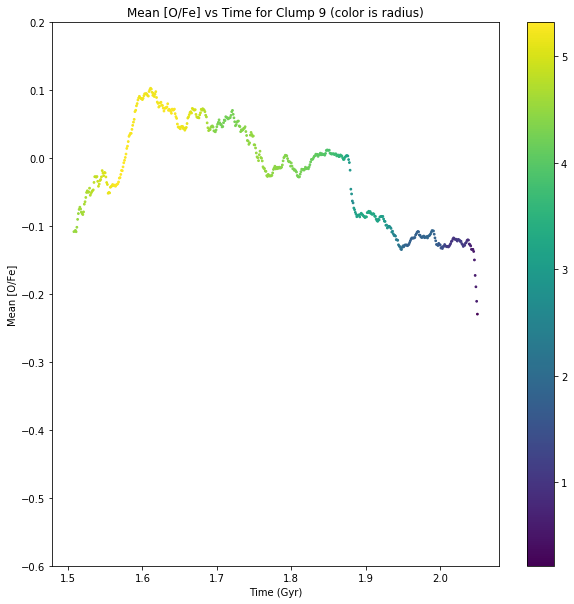

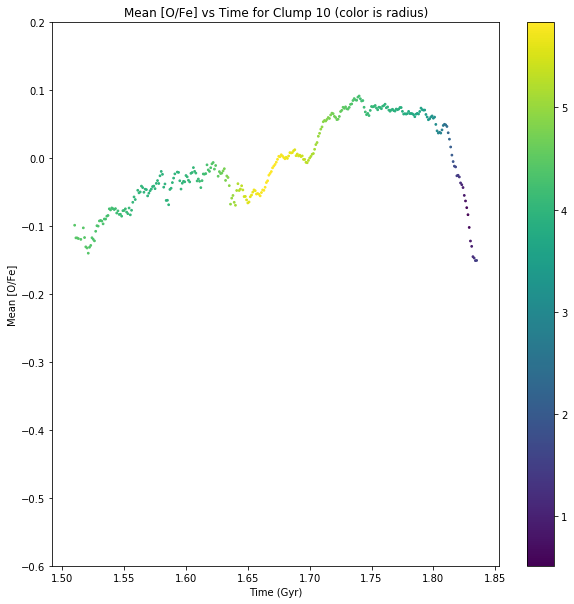

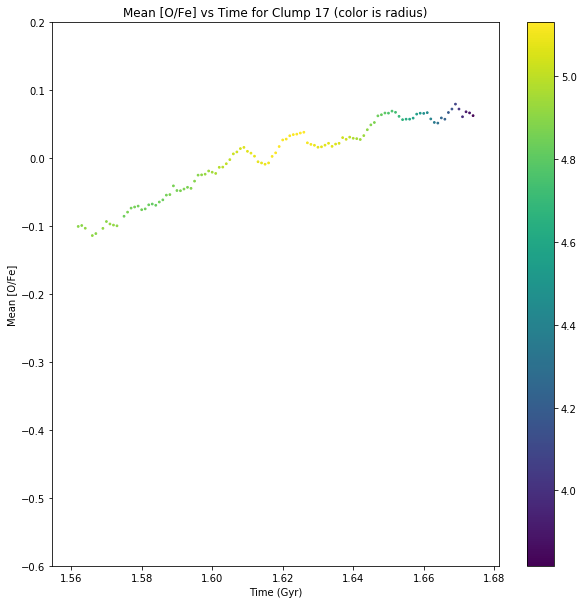

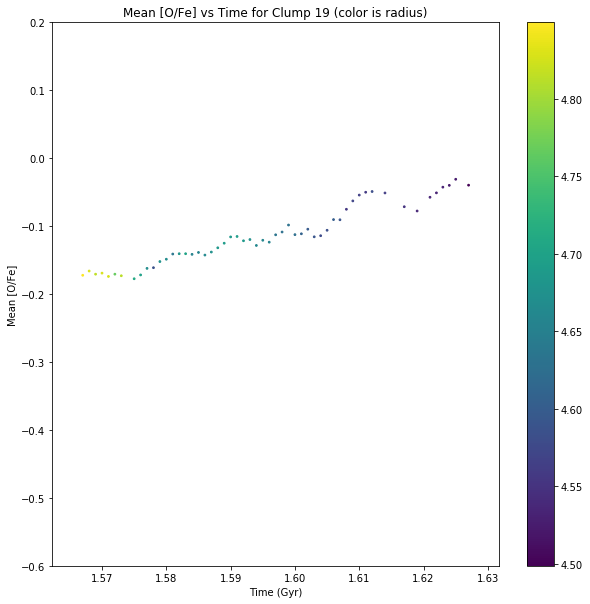

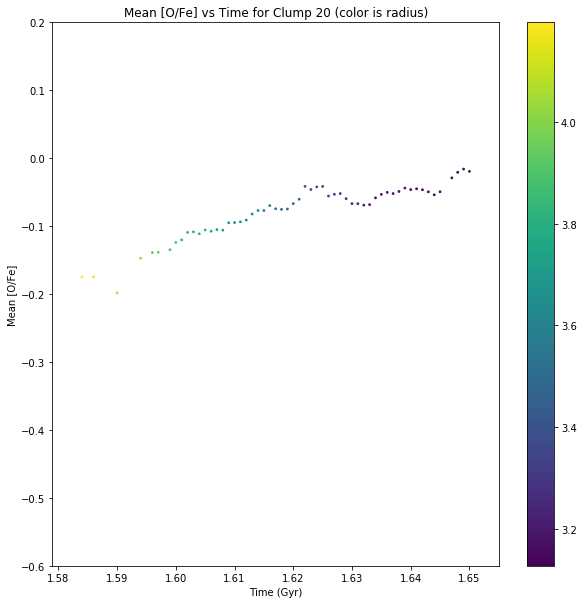

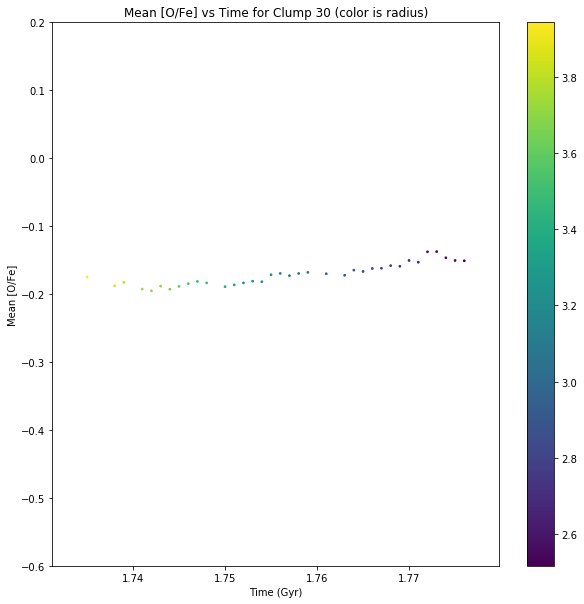

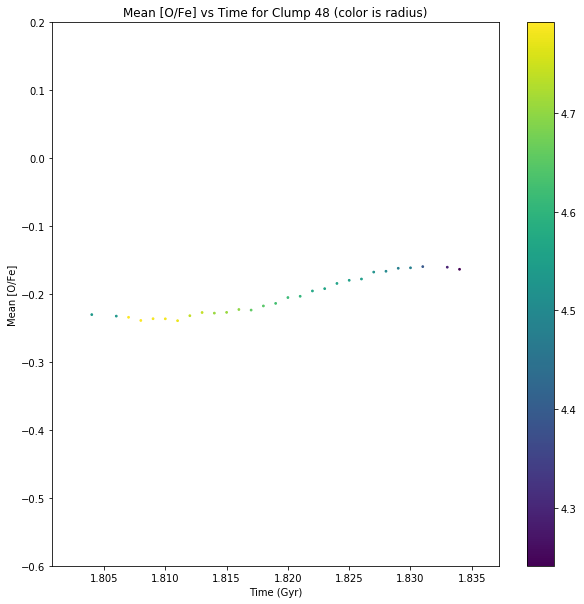

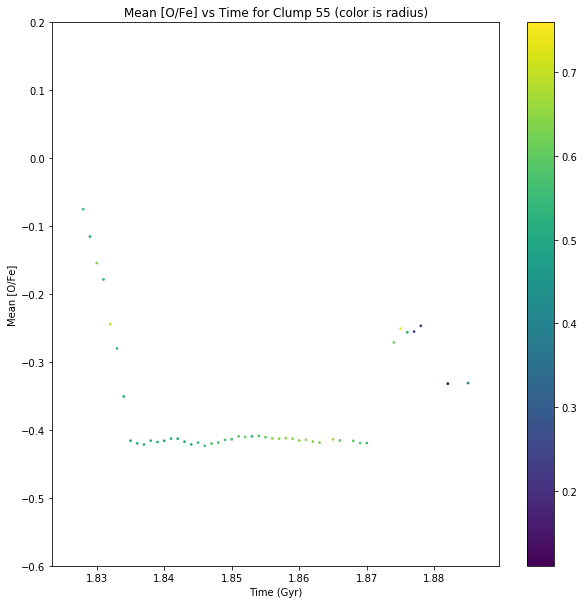

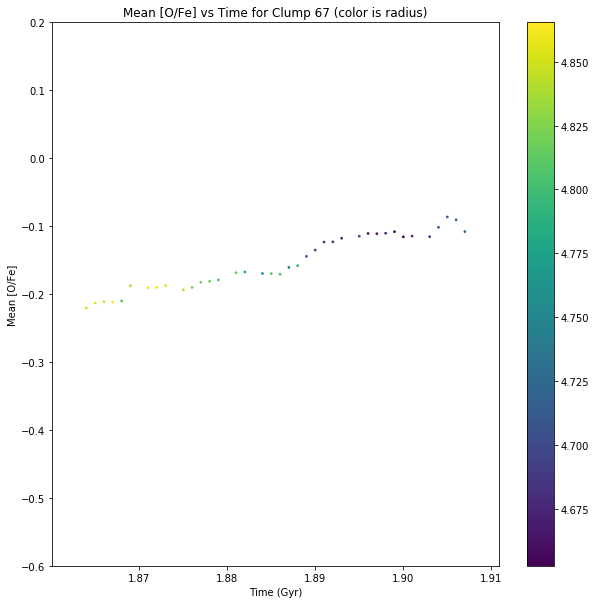

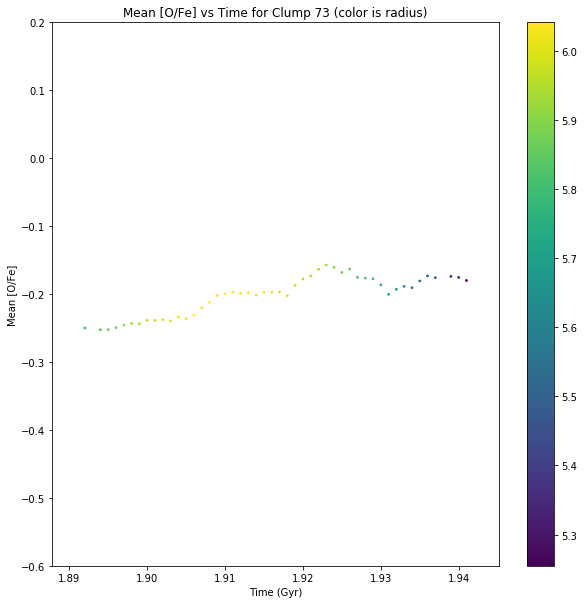

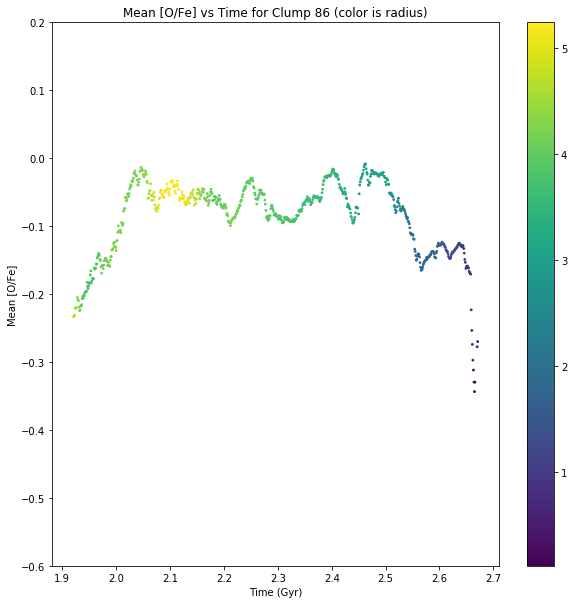

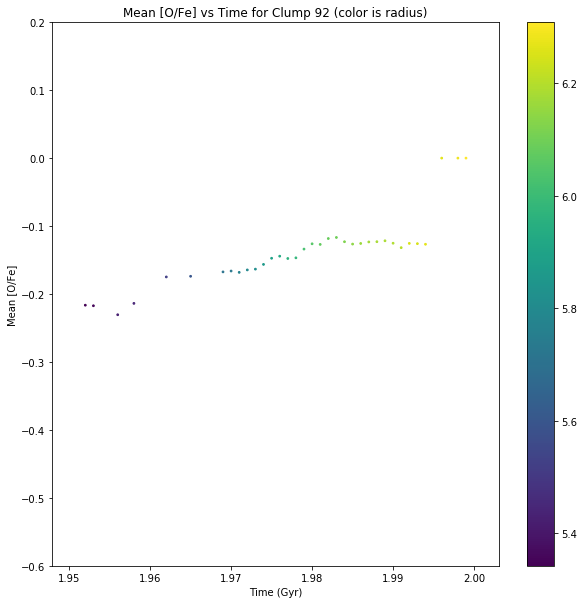

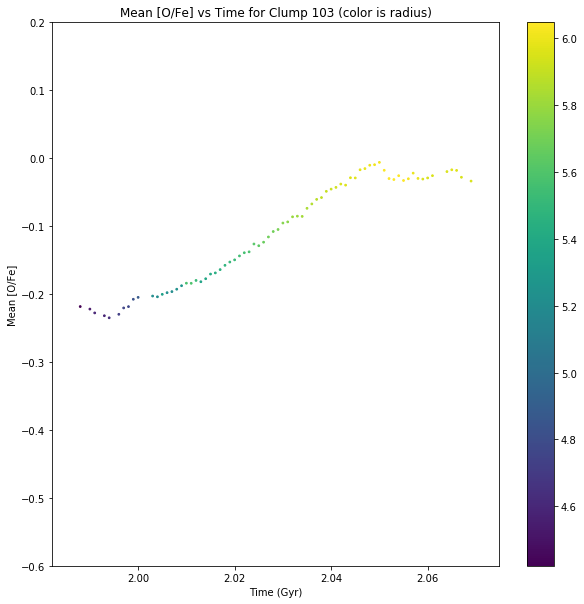

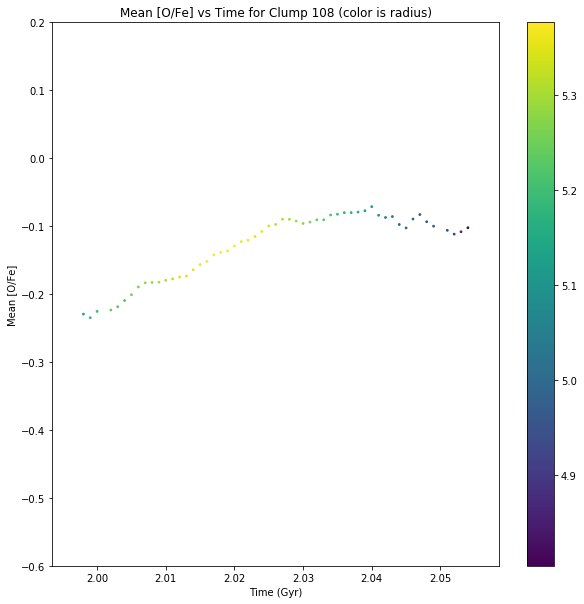

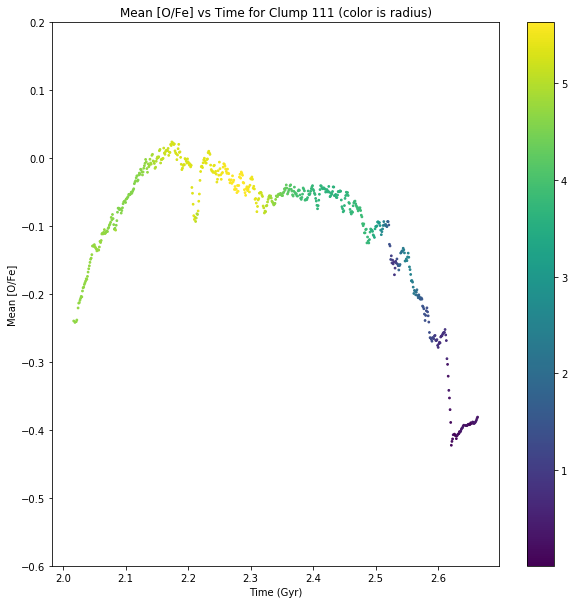

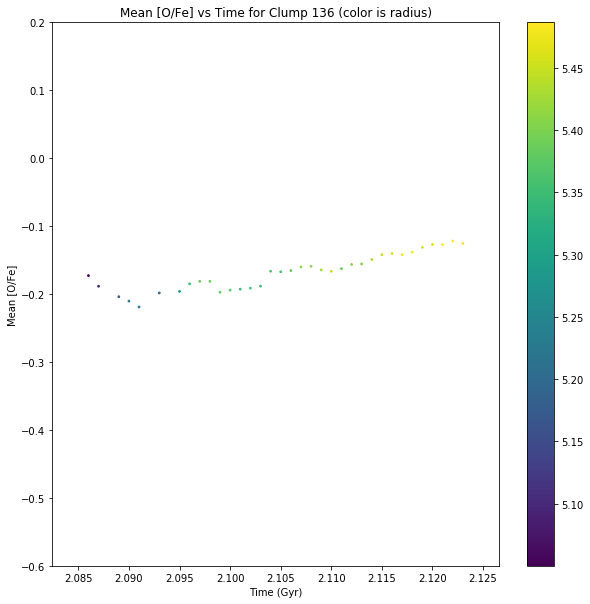

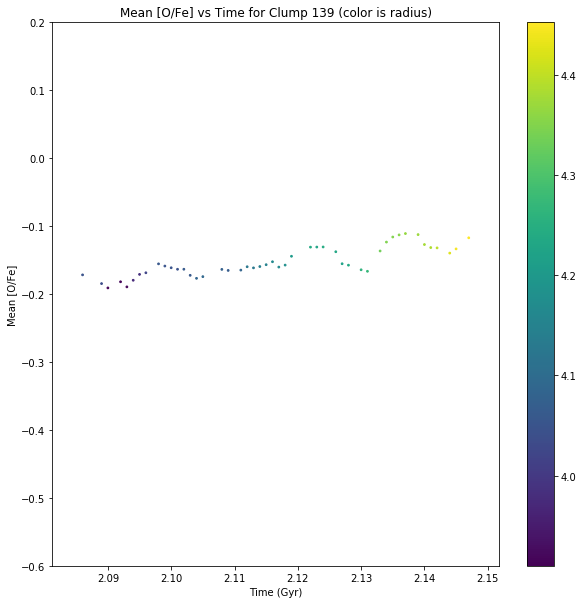

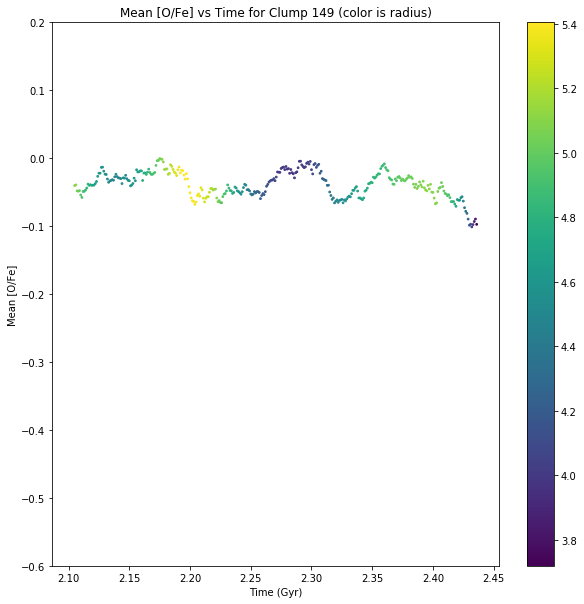

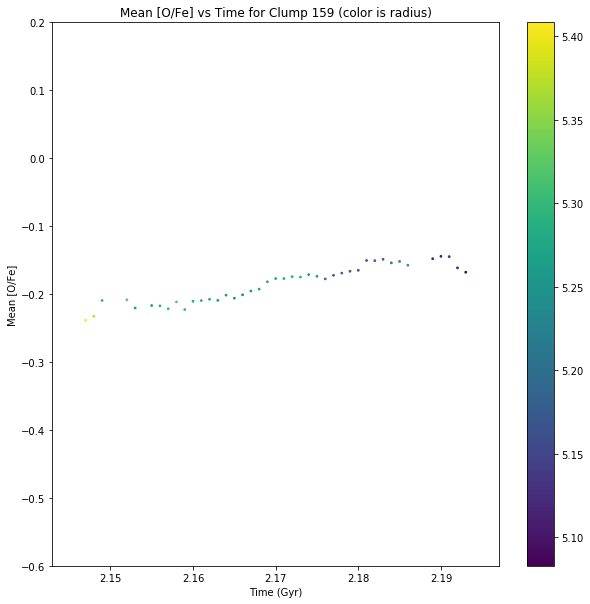

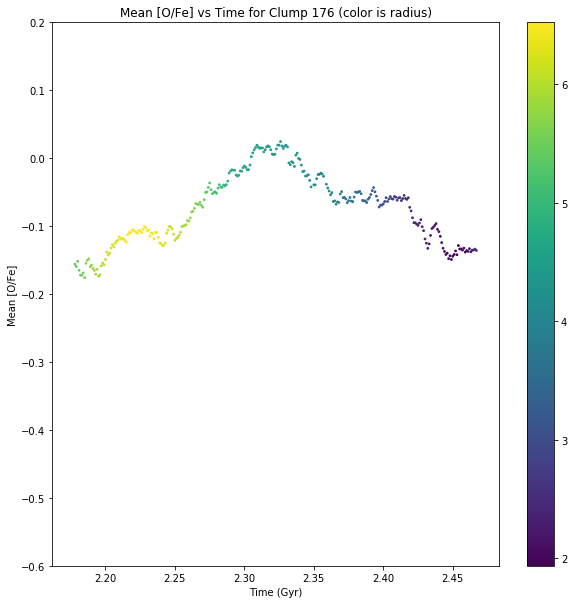

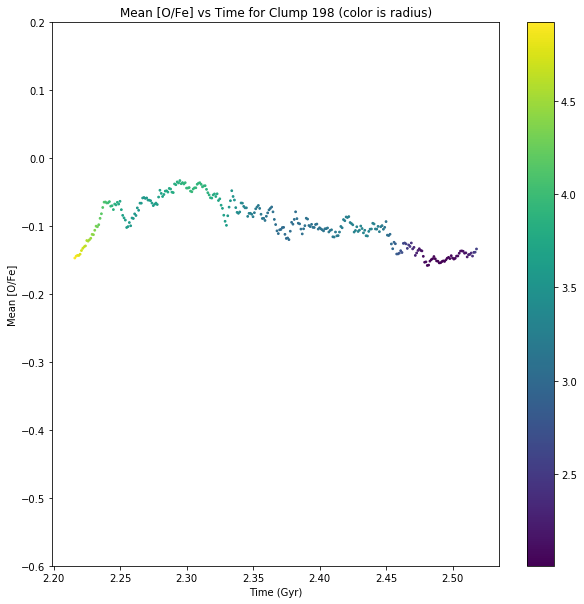

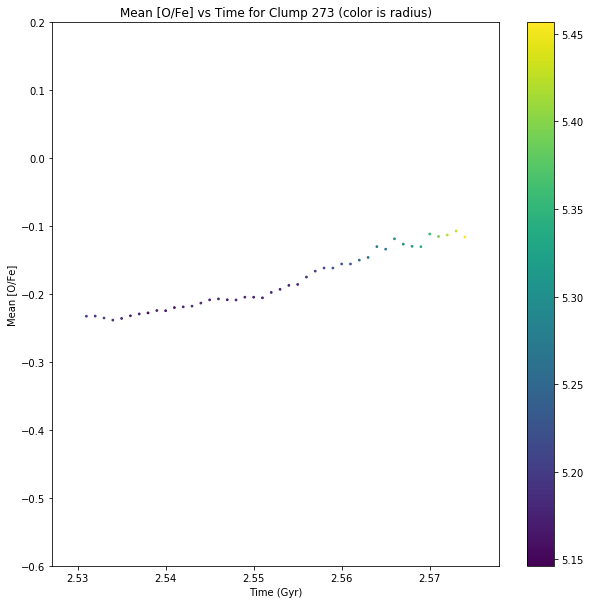

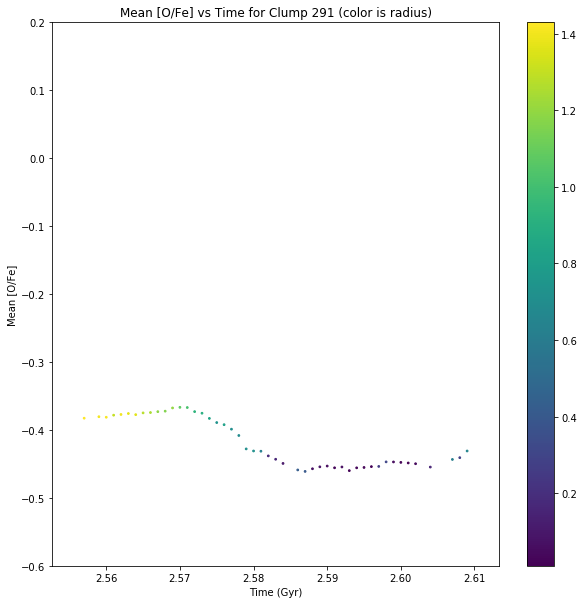

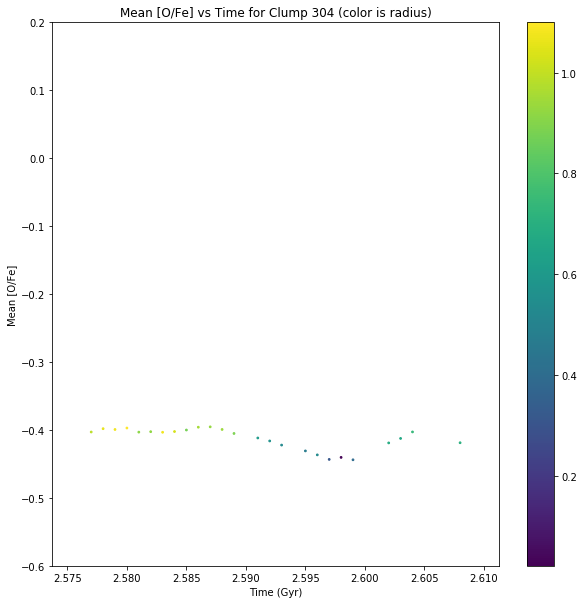

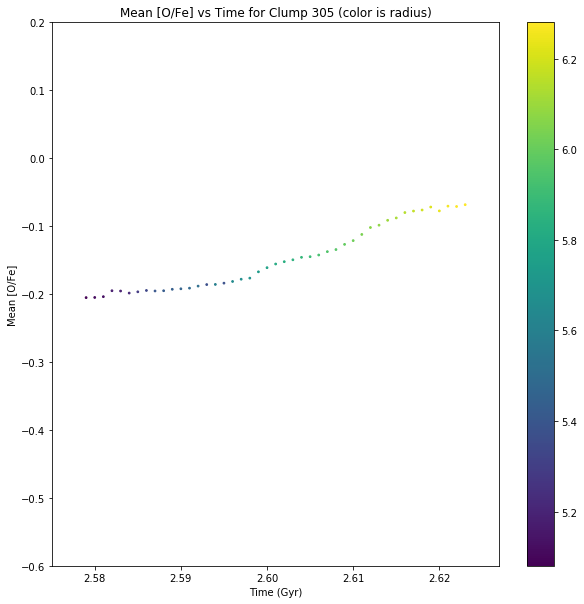

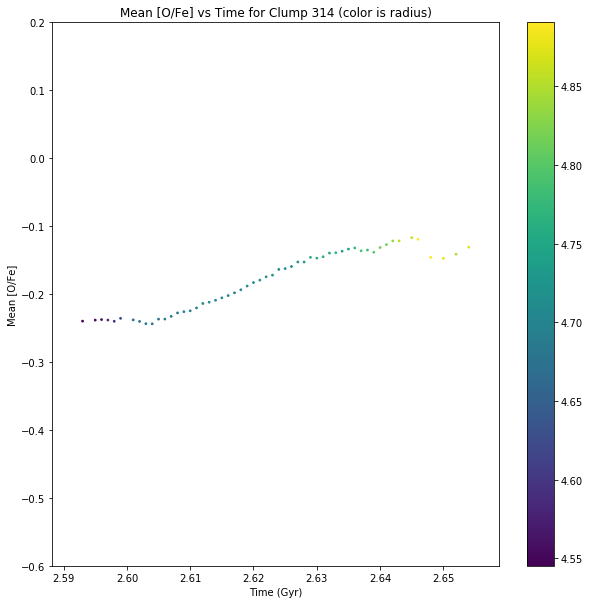

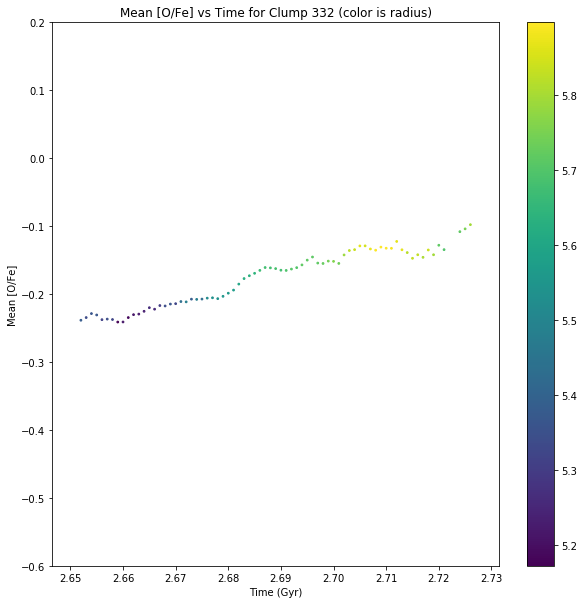

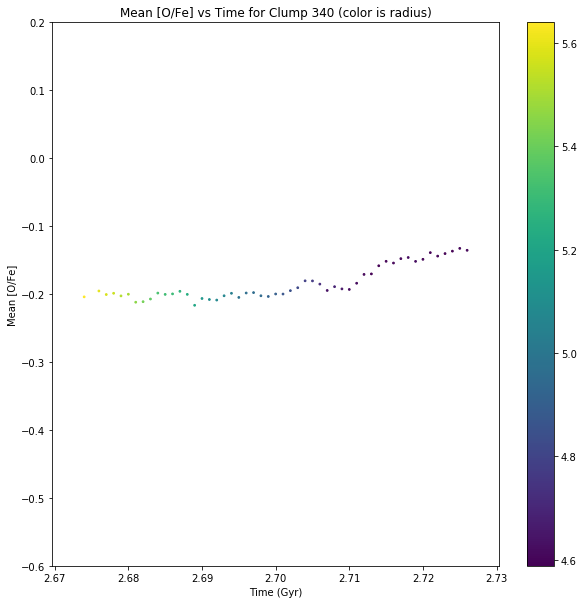

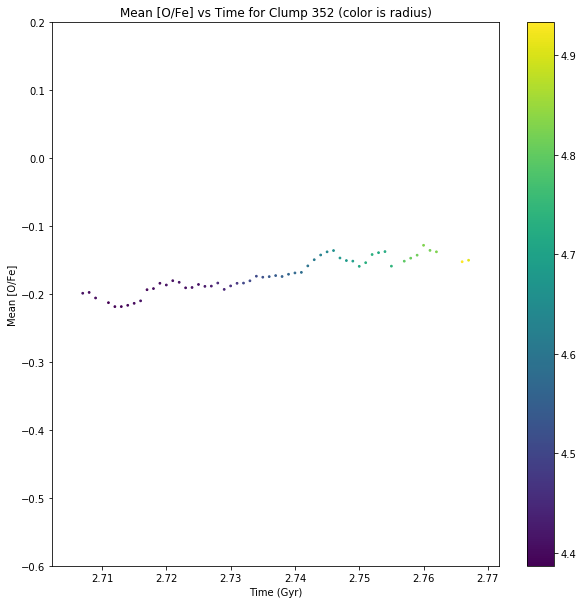

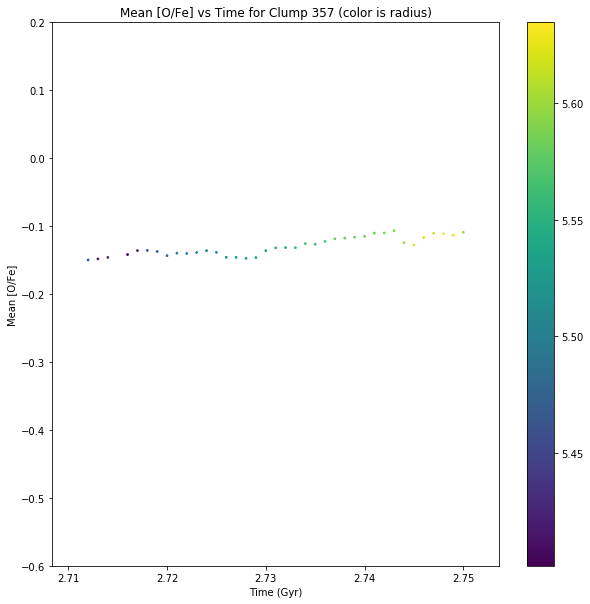

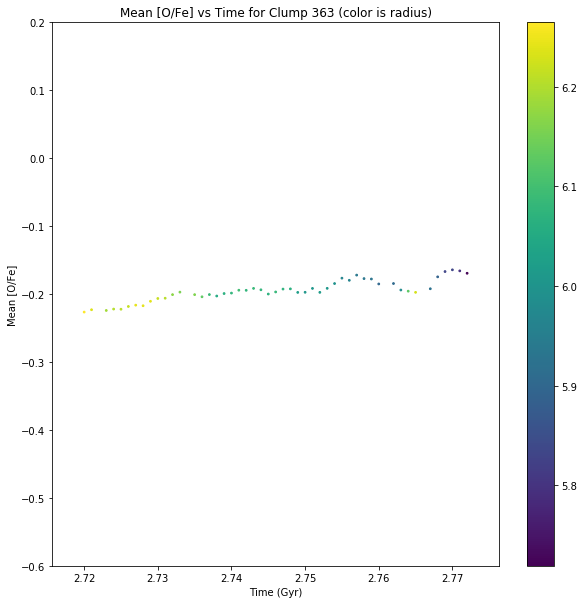

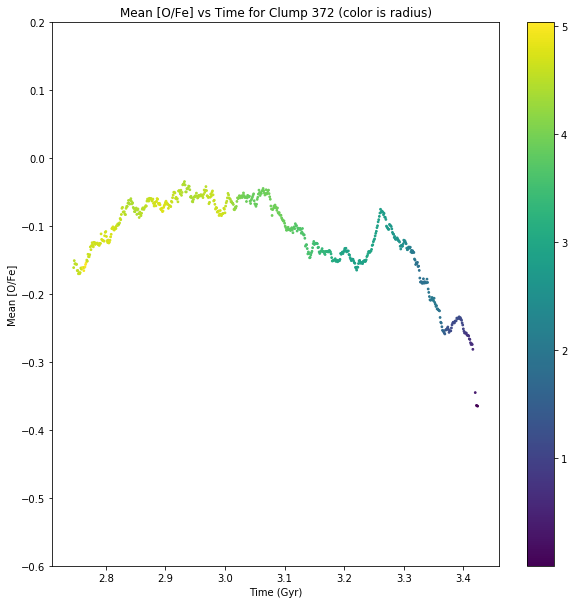

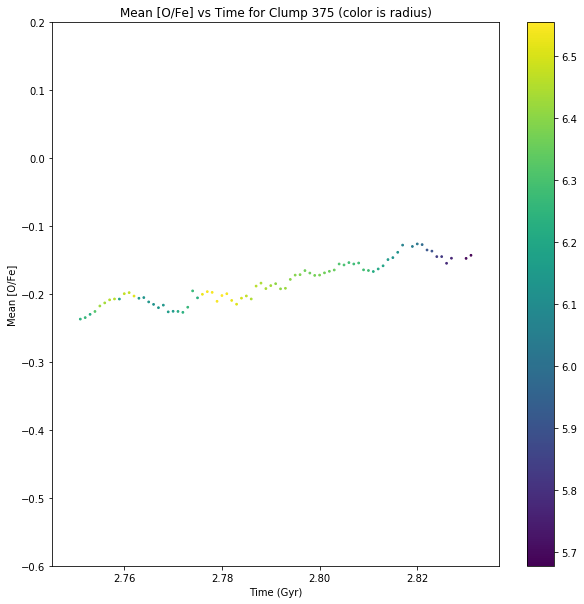

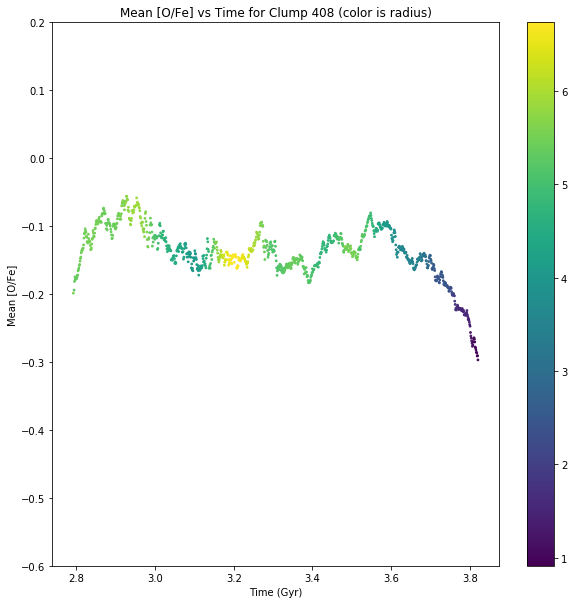

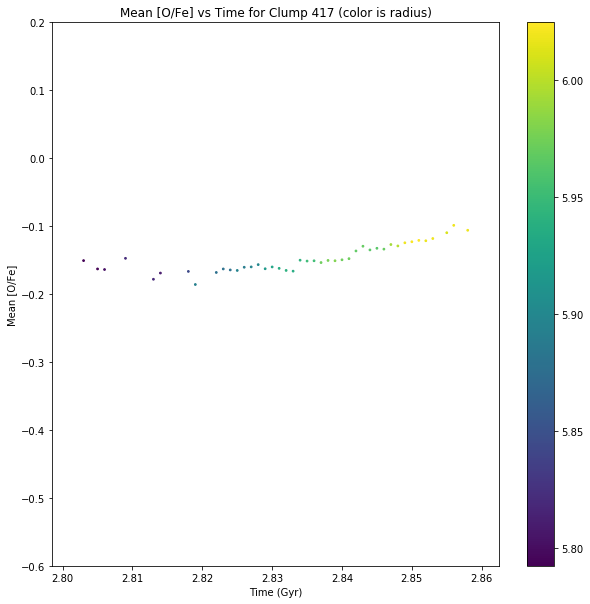

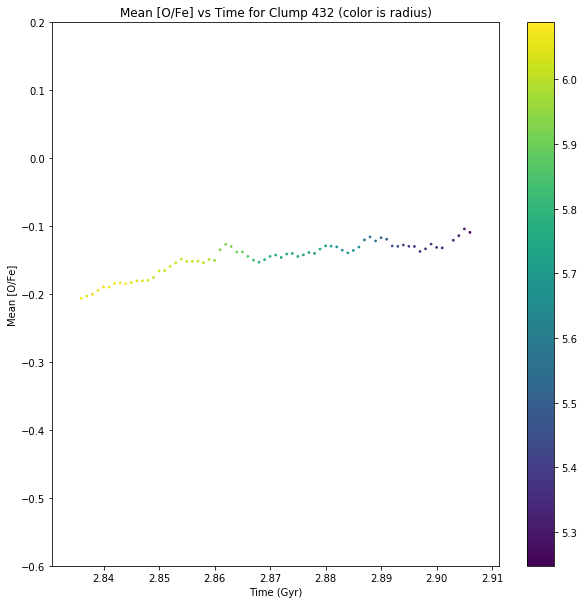

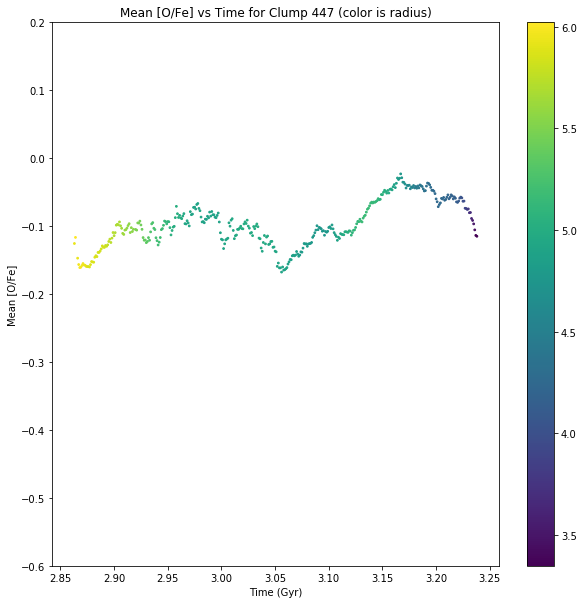

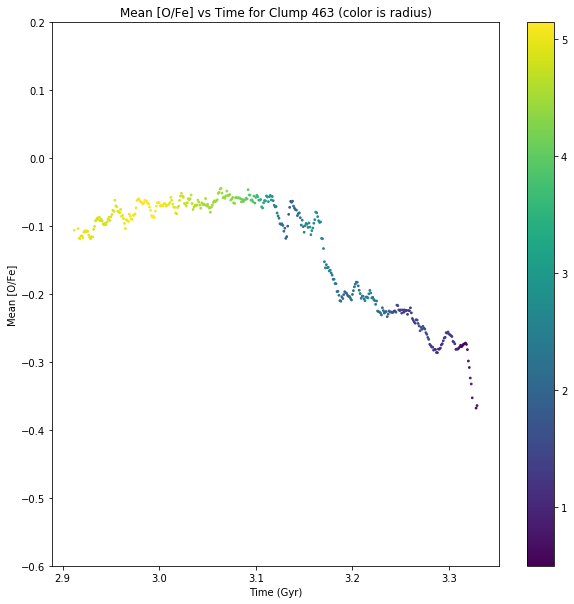

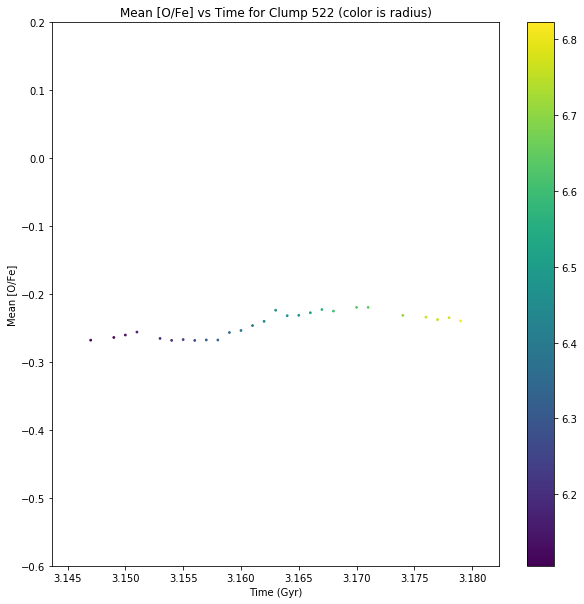

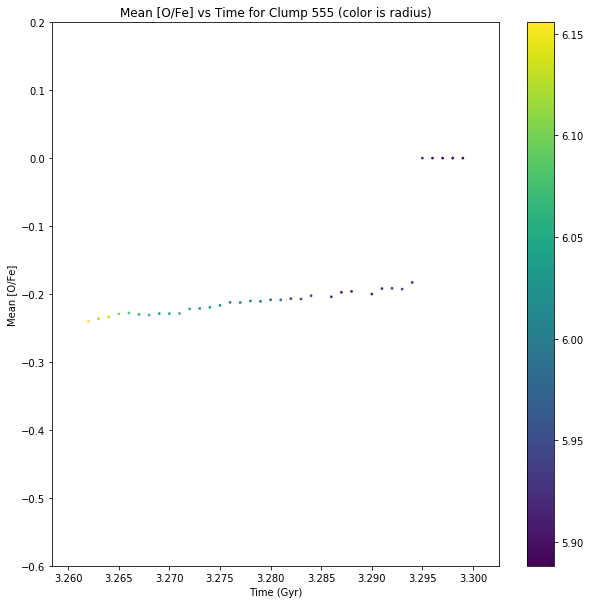

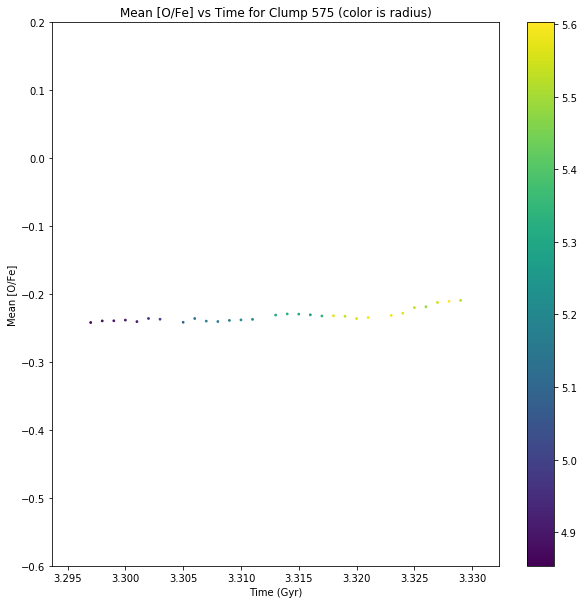

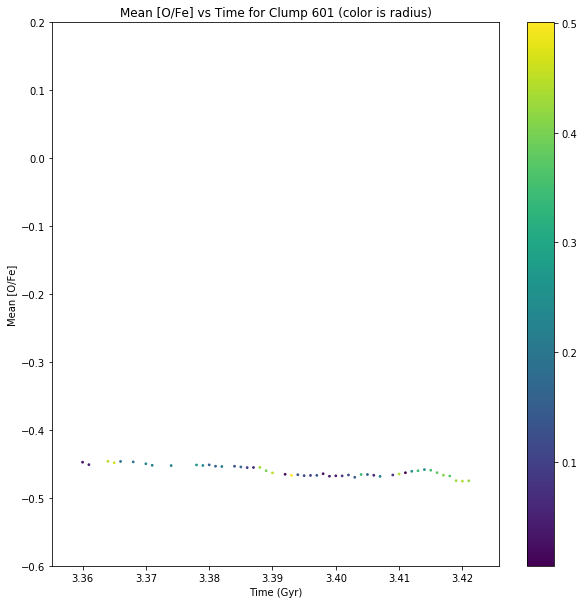

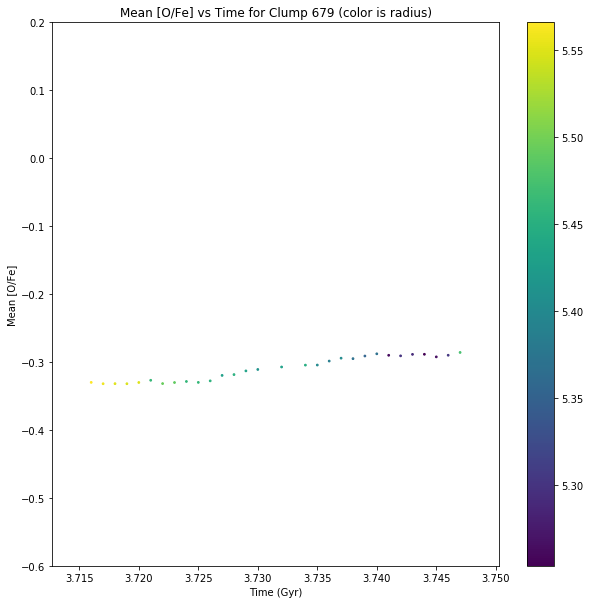

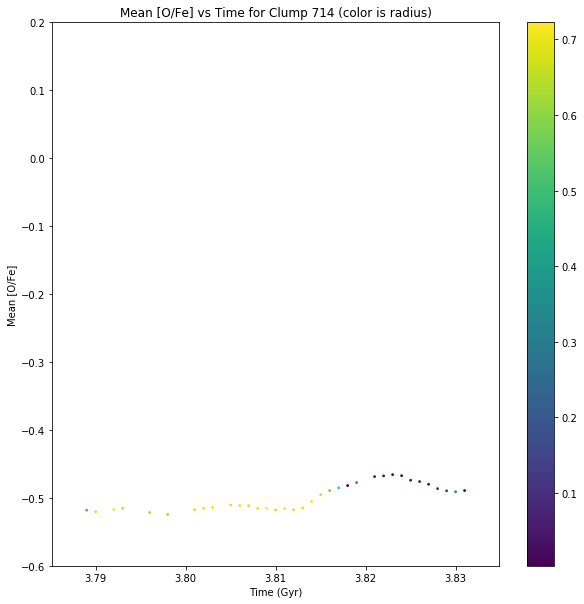

In [17]:
for clumpid in np.unique(np.array(txy['CLUMPID'])):
    plt.figure(figsize=(10,10))
    txyclump = txy[(txy['CLUMPID']==clumpid)]
    plt.scatter(txyclump['TIME'],txyclump['MEANOFE'],c=(txyclump['X']**2+txyclump['Y']**2)**(1/2),s=3)
    plt.colorbar()
    plt.xlabel('Time (Gyr)')
    plt.ylabel('Mean [O/Fe]')
    plt.title('Mean [O/Fe] vs Time for Clump {} (color is radius)'.format(clumpid))
    plt.ylim((-0.6,0.2))

C:\Users\betha\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


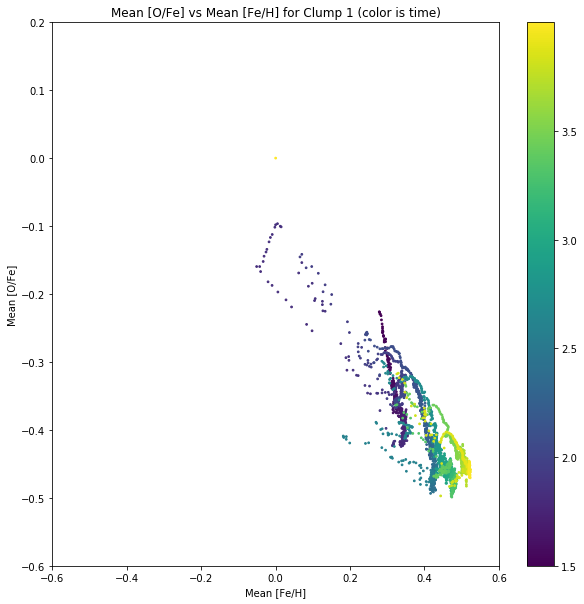

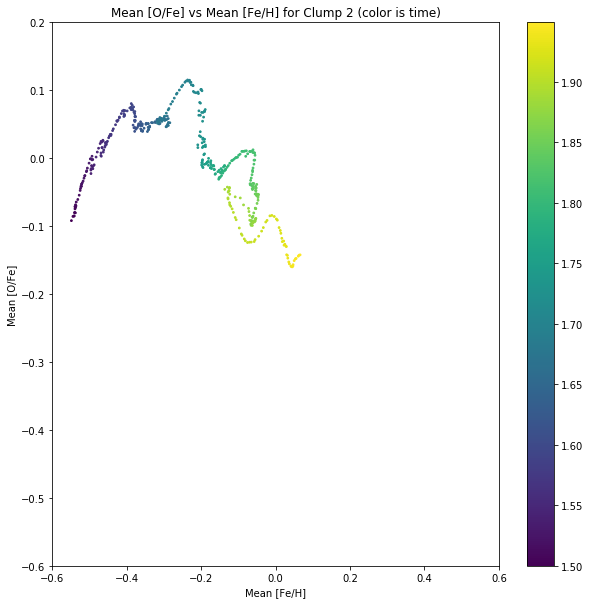

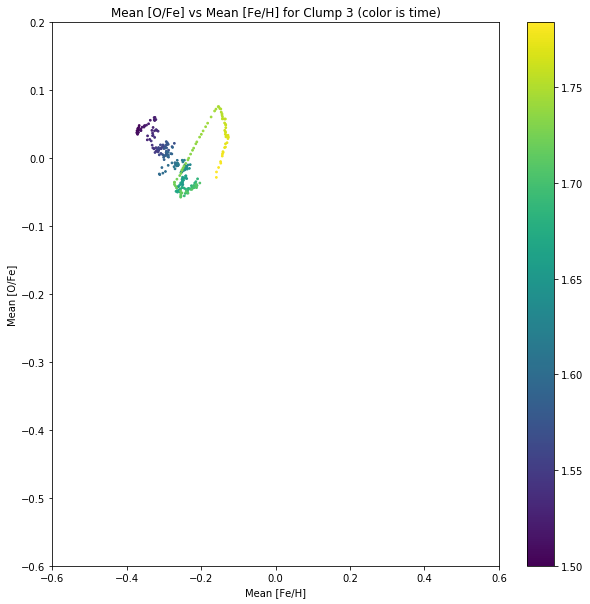

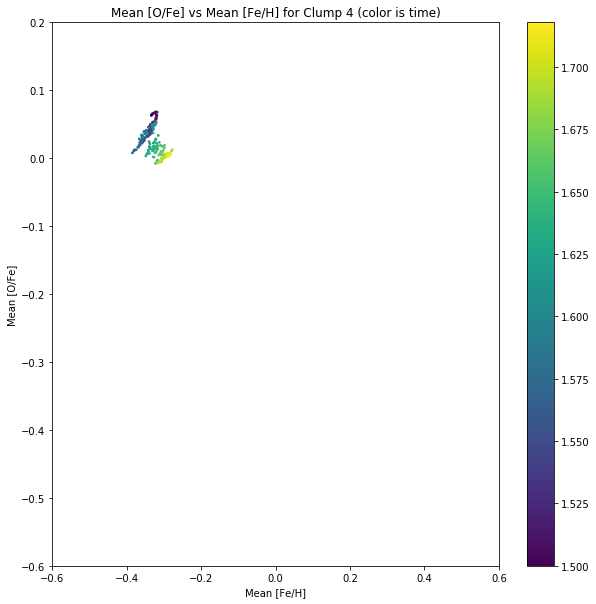

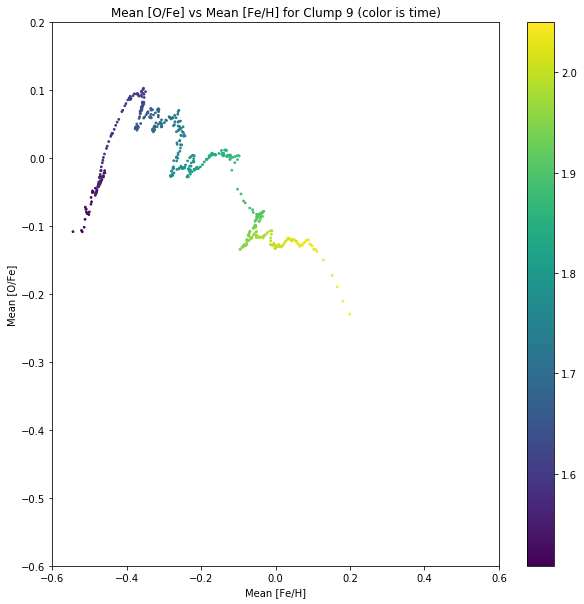

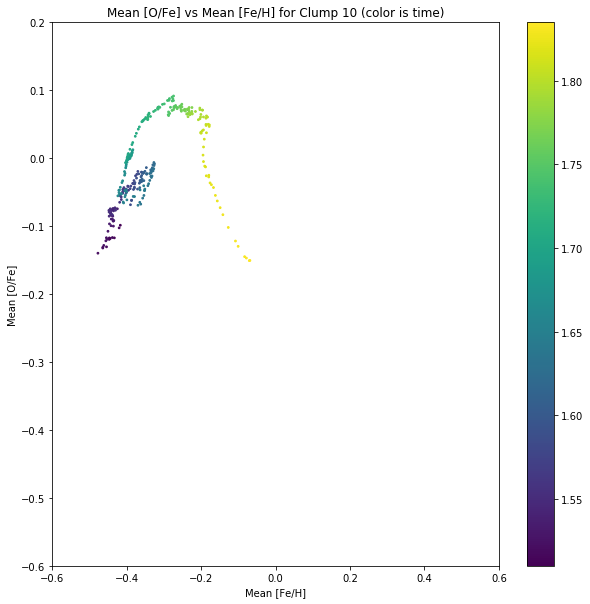

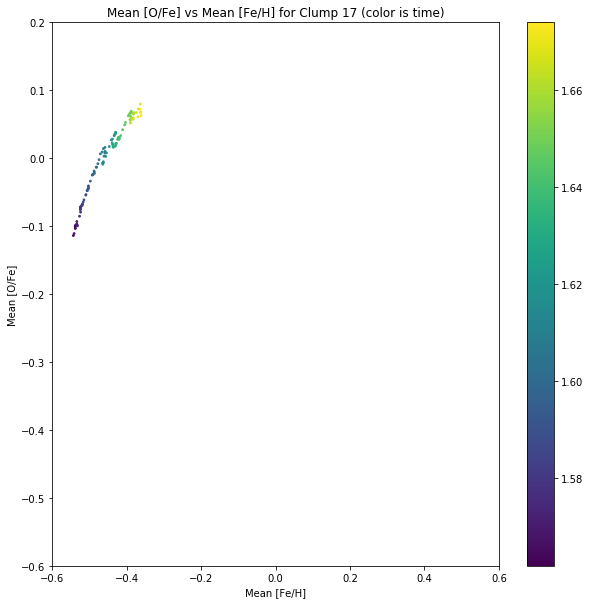

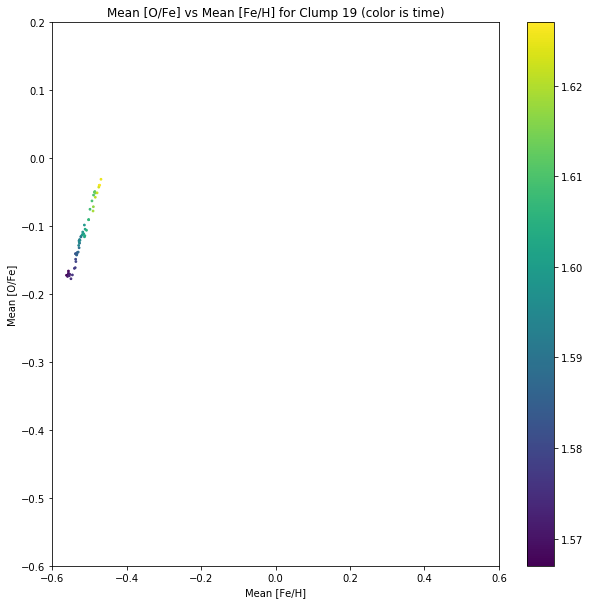

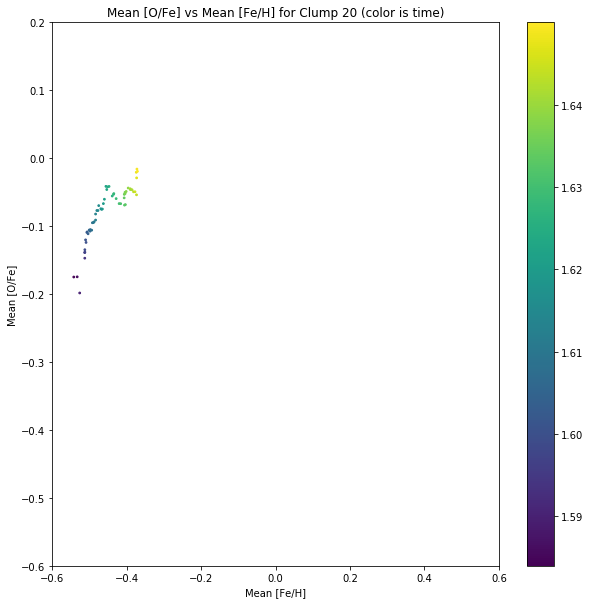

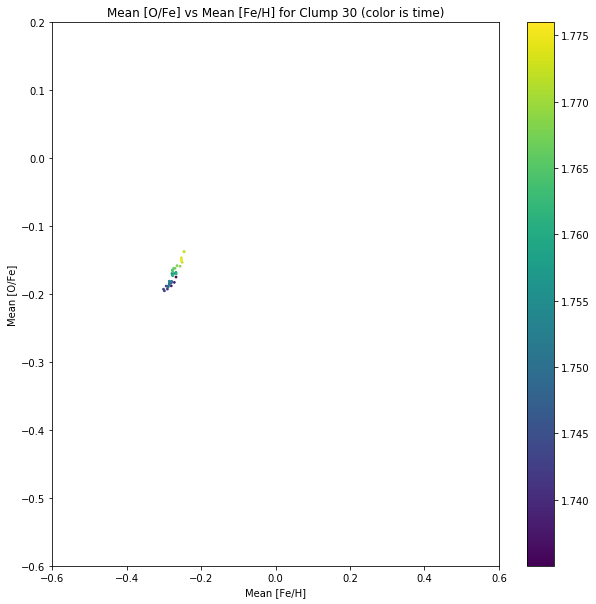

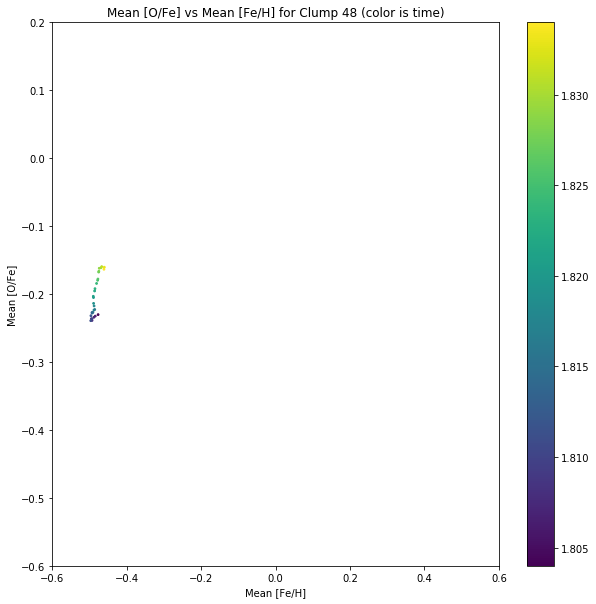

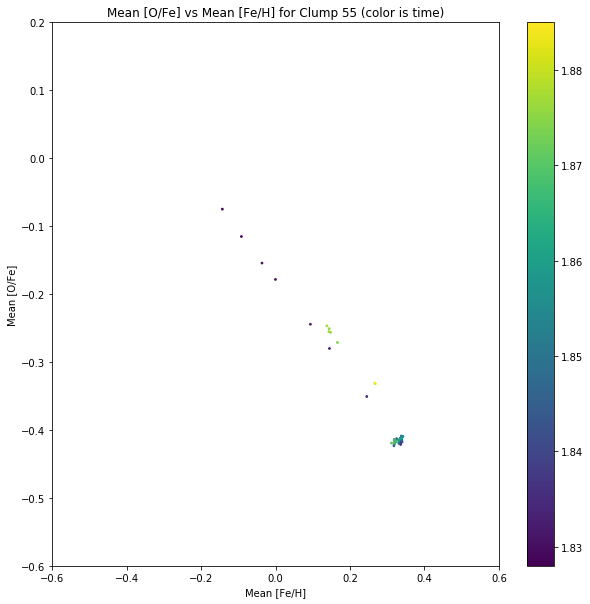

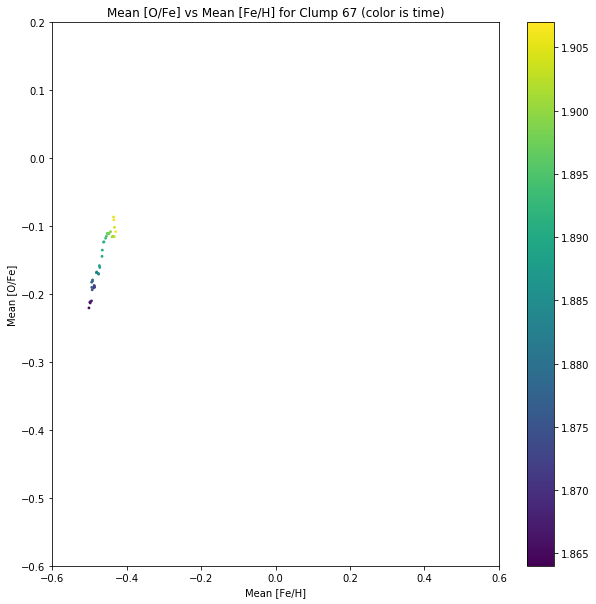

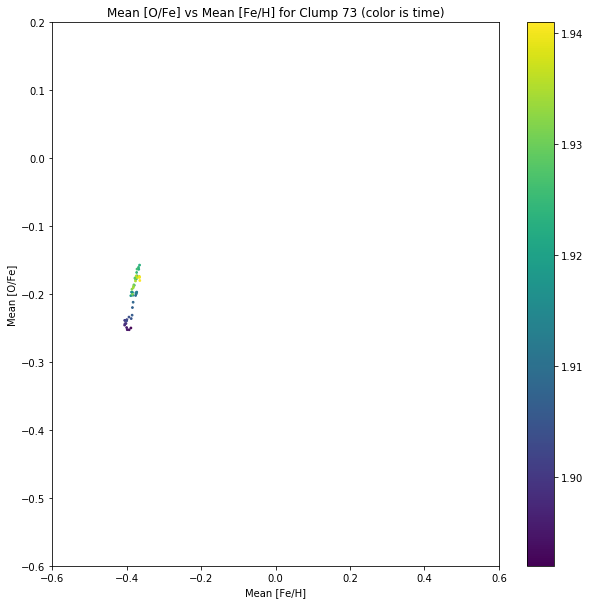

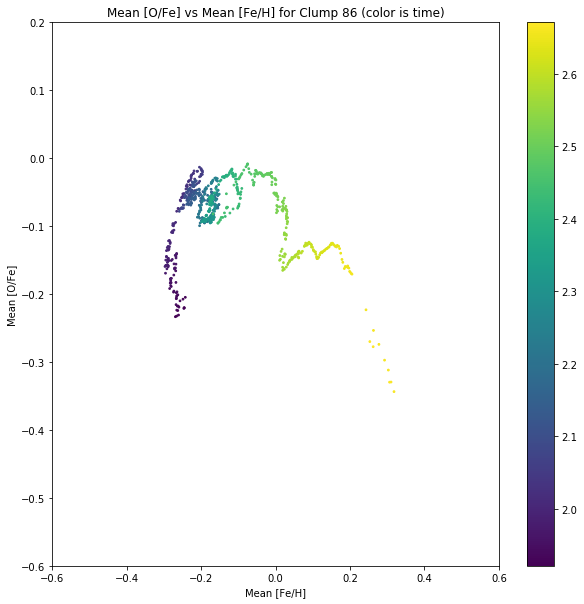

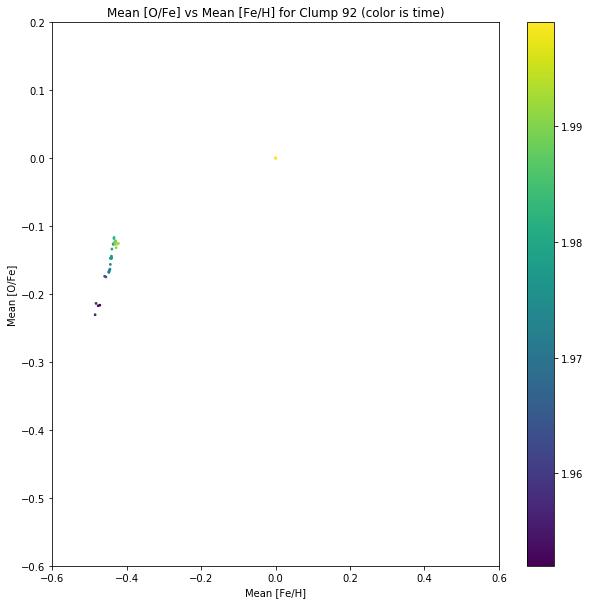

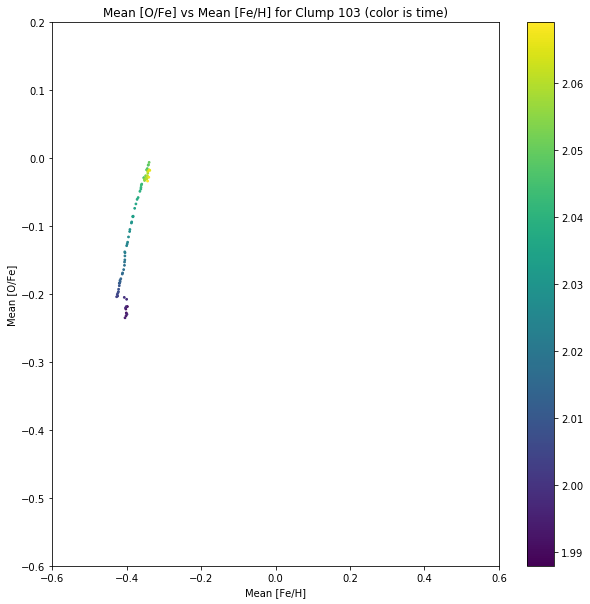

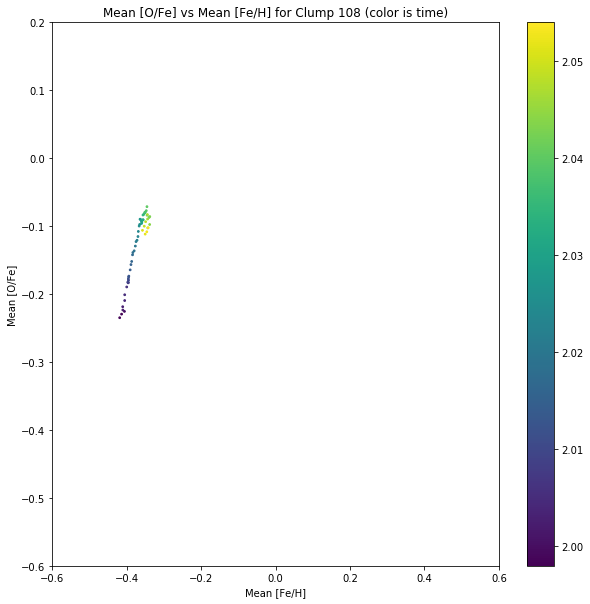

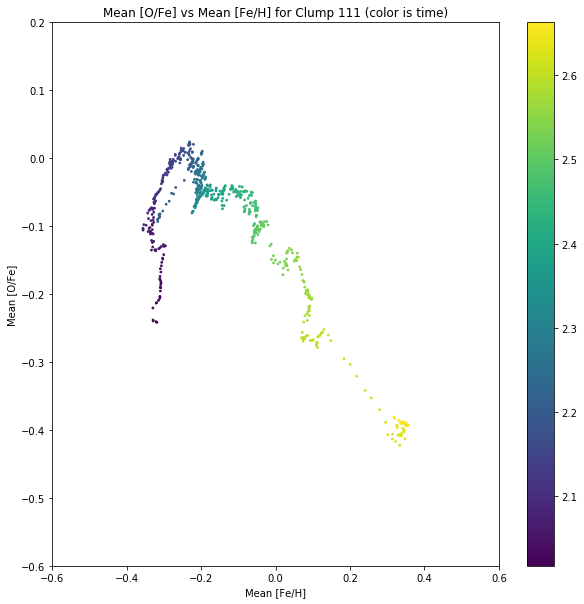

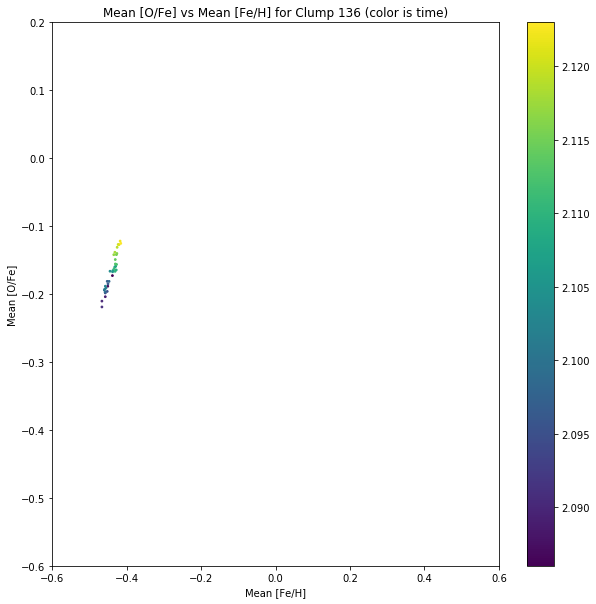

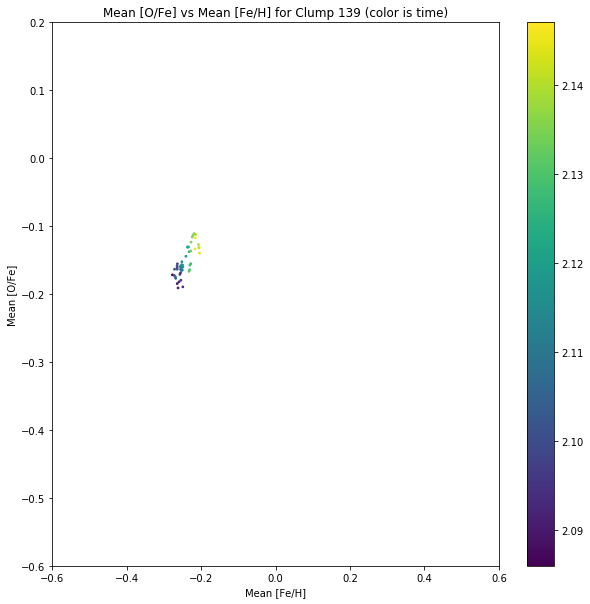

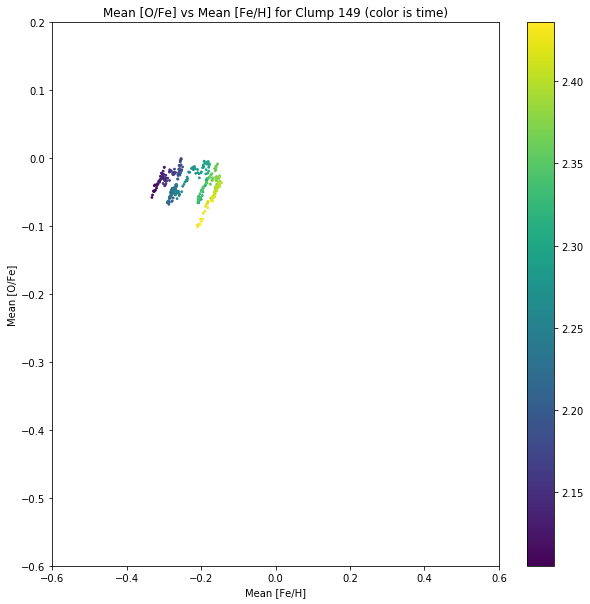

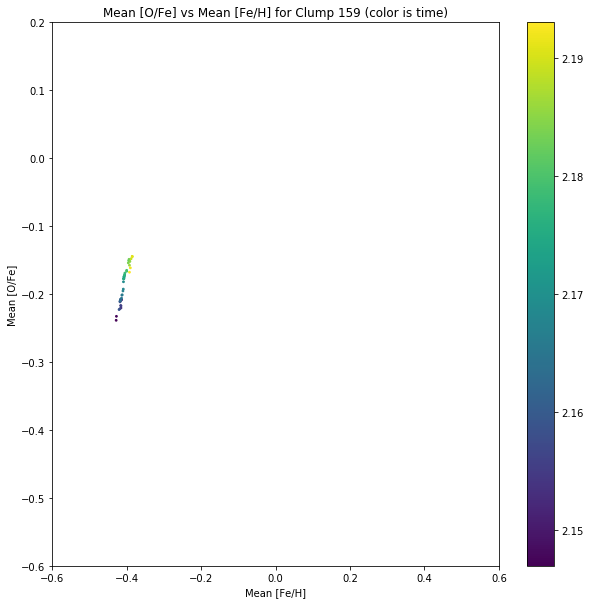

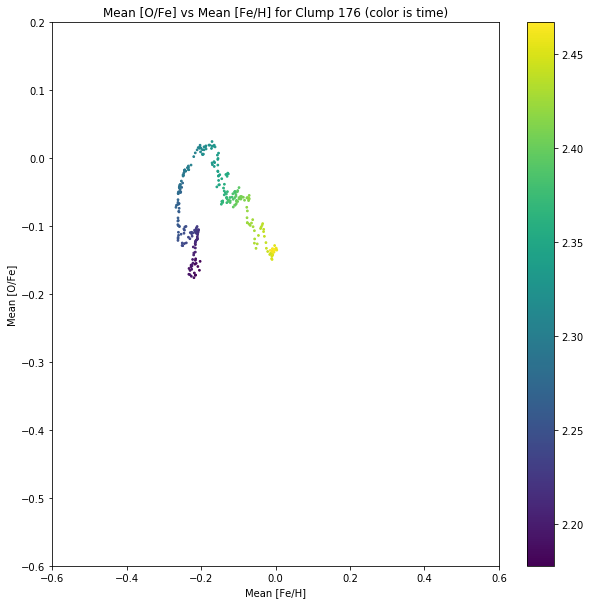

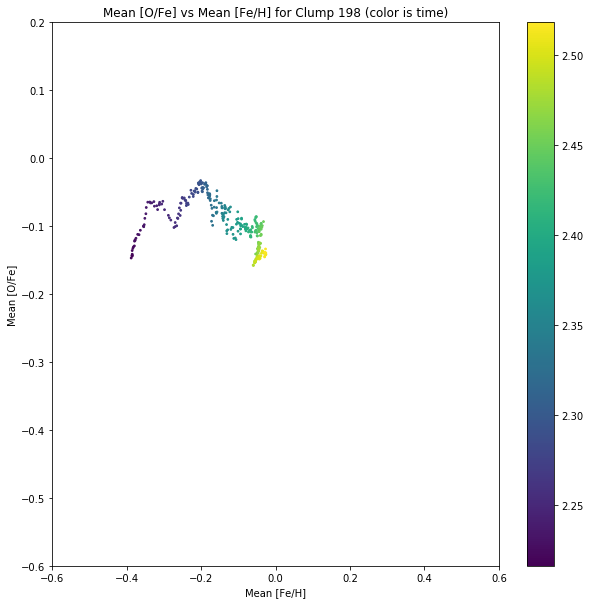

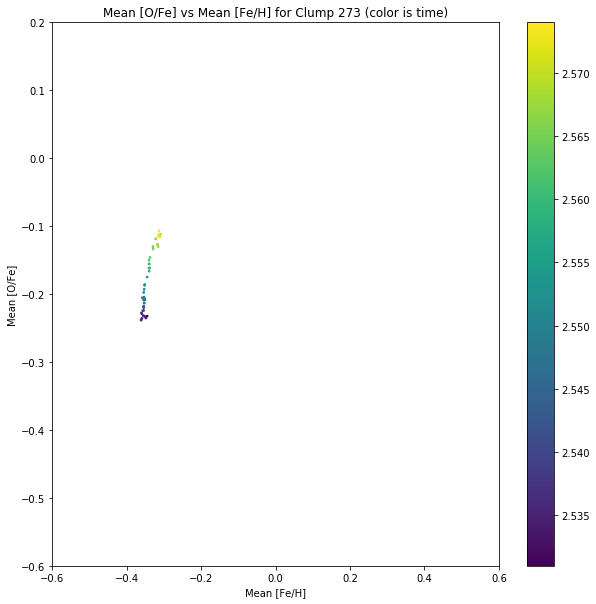

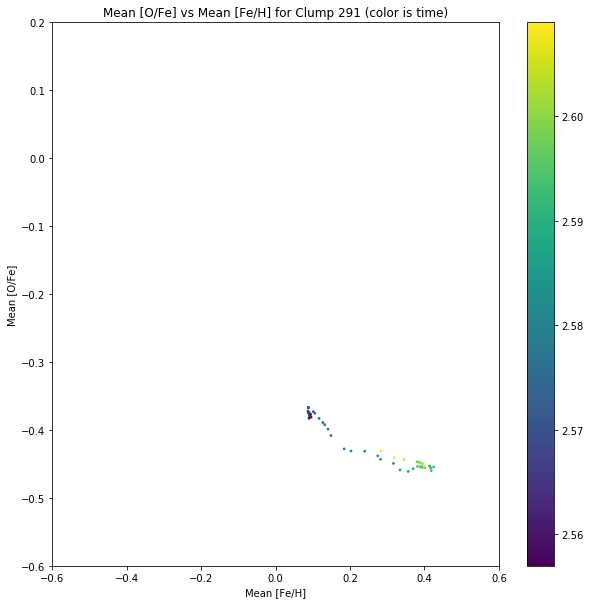

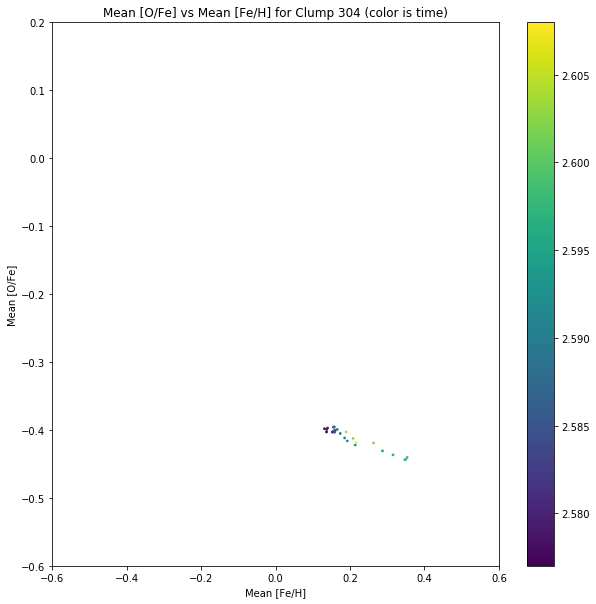

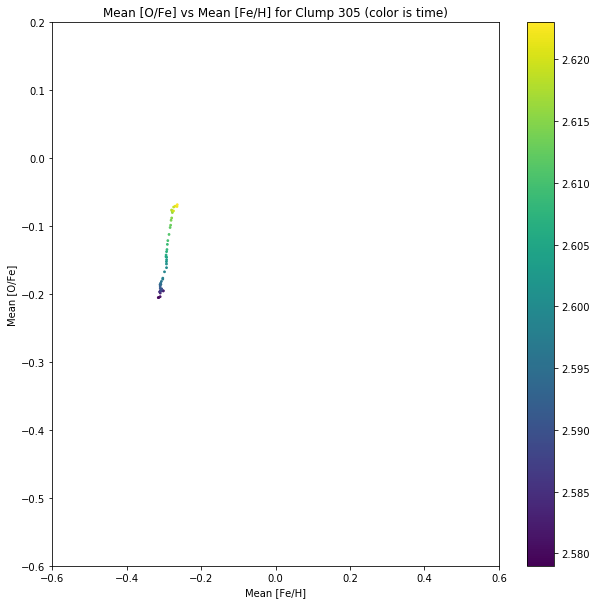

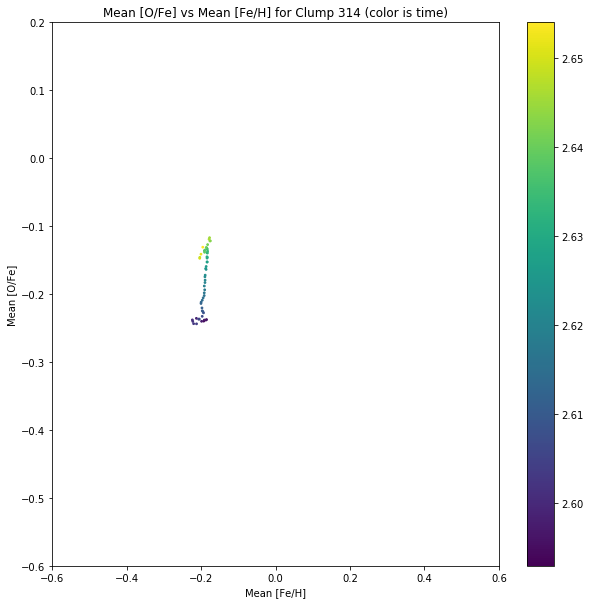

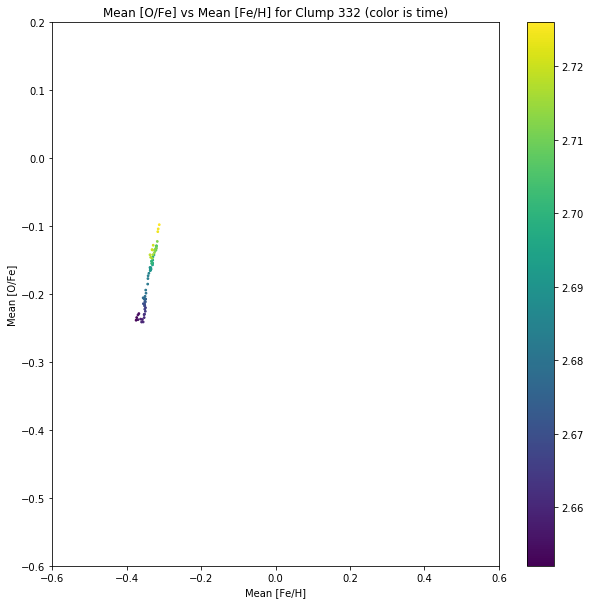

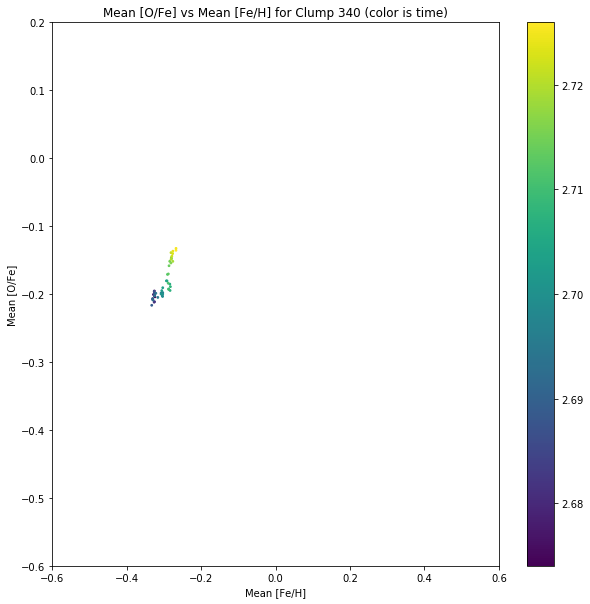

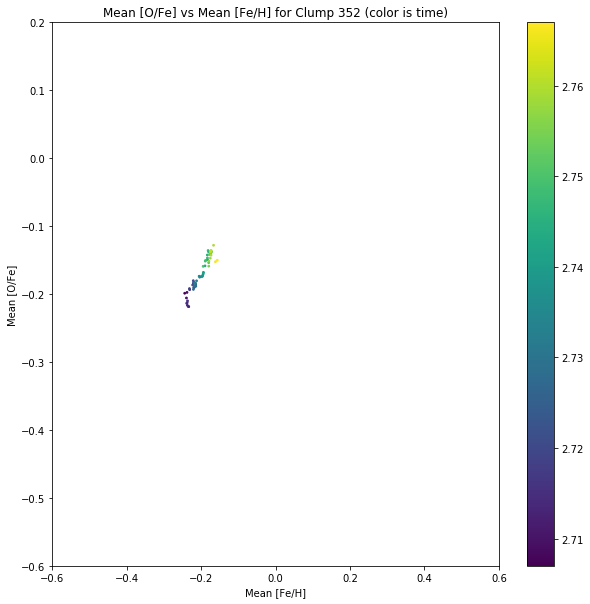

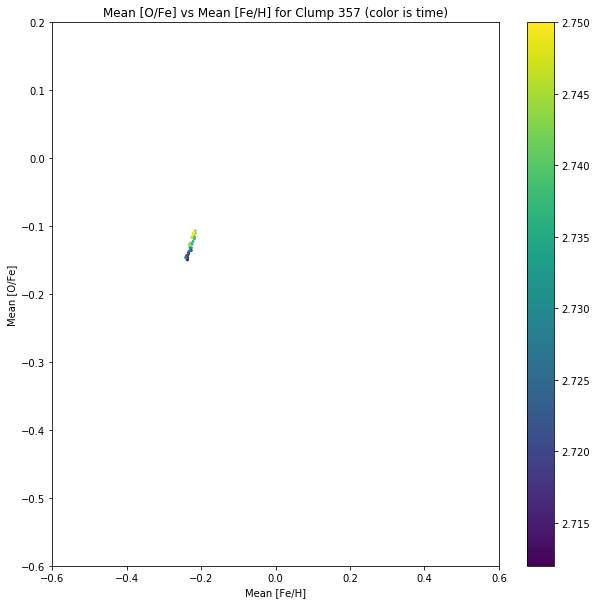

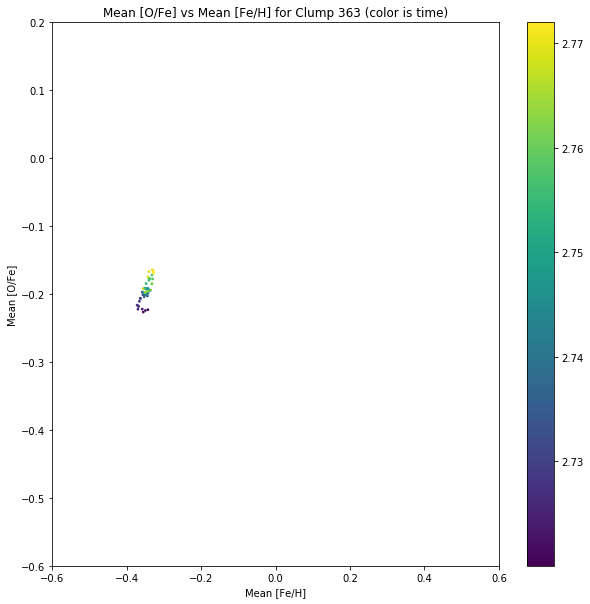

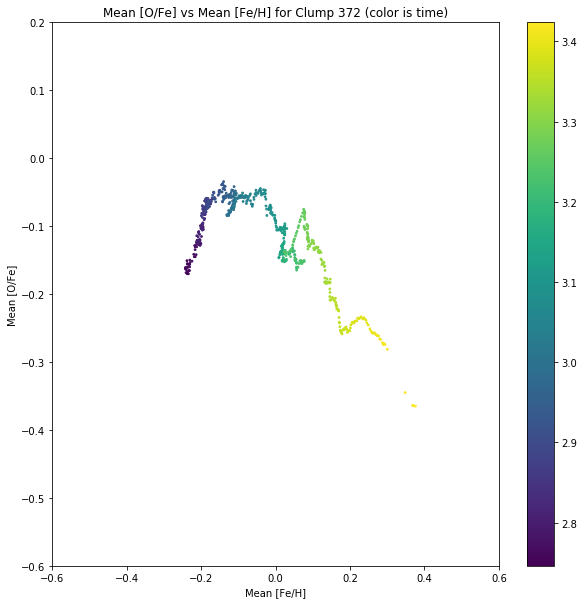

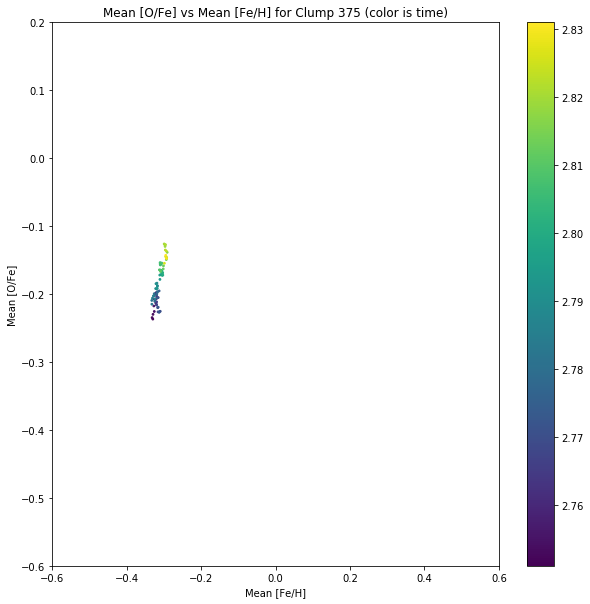

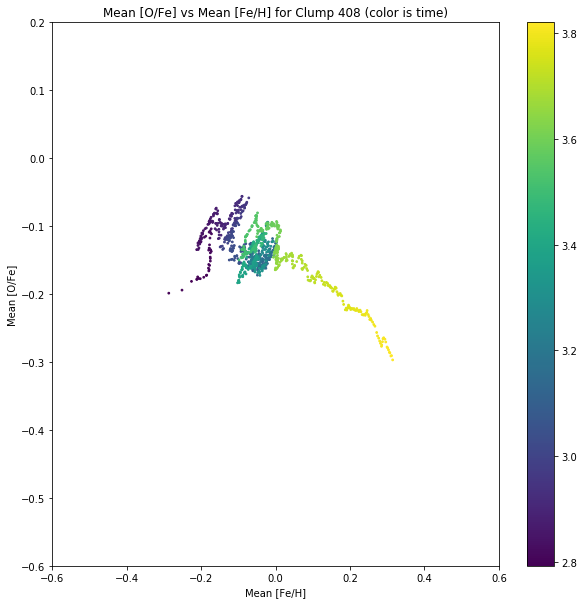

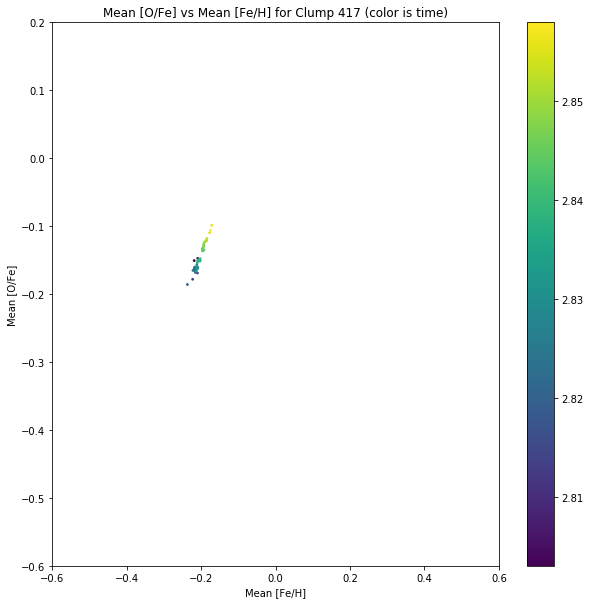

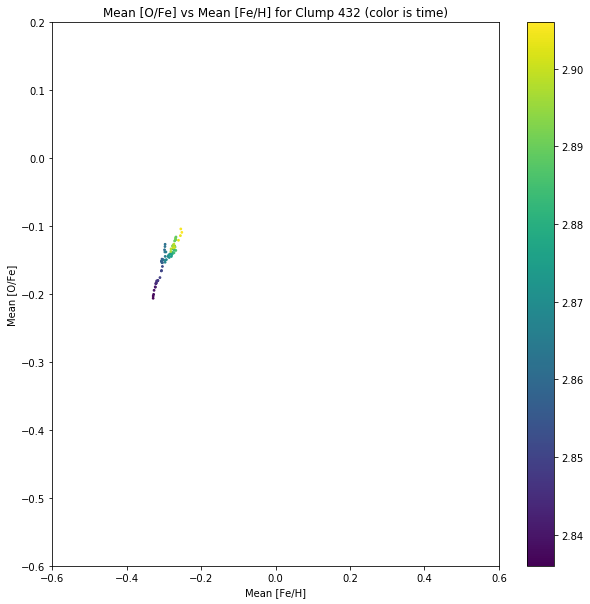

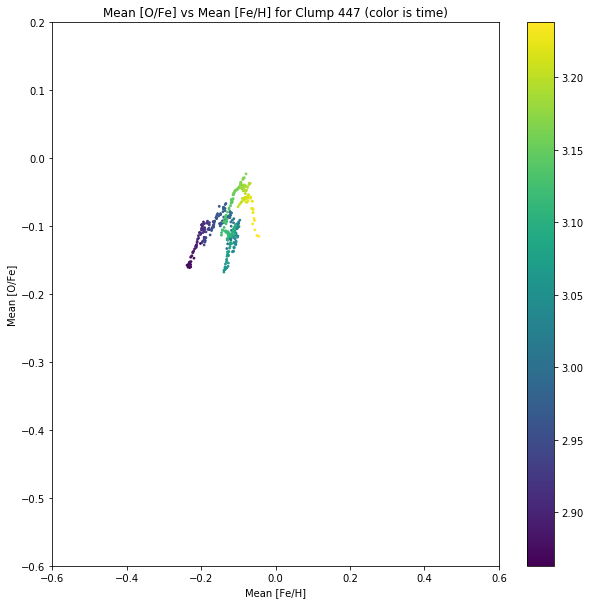

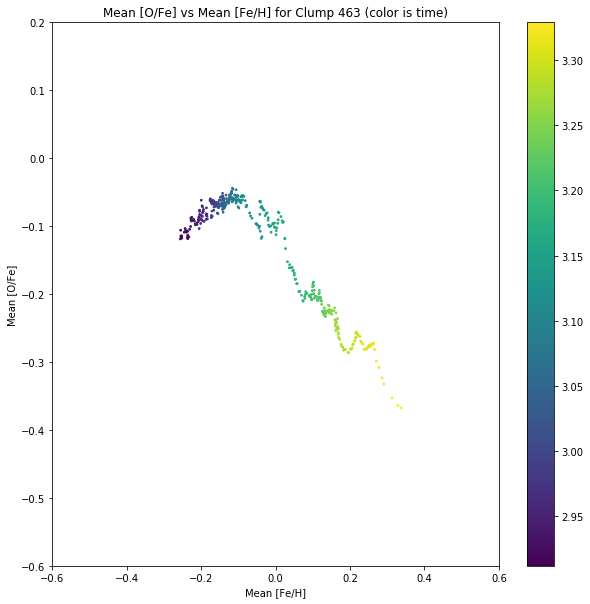

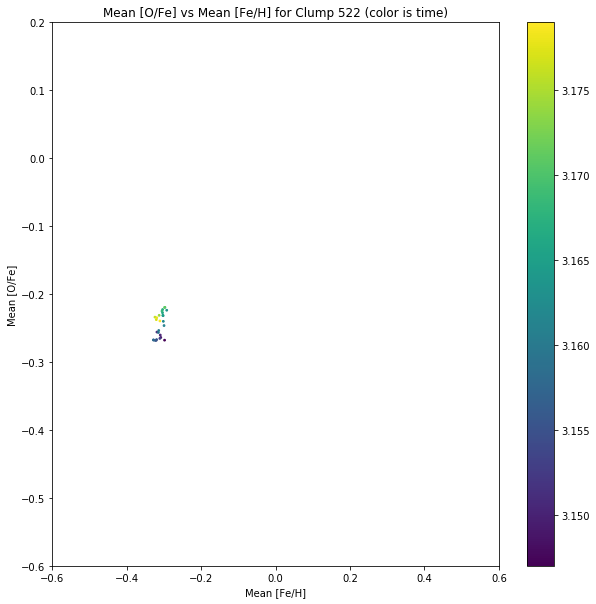

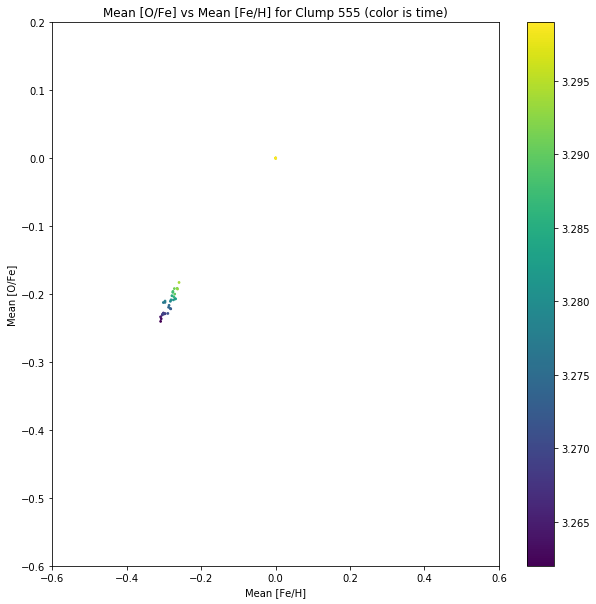

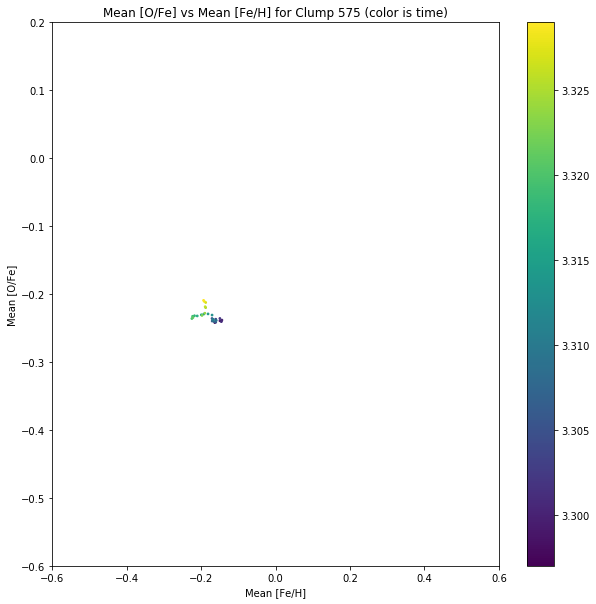

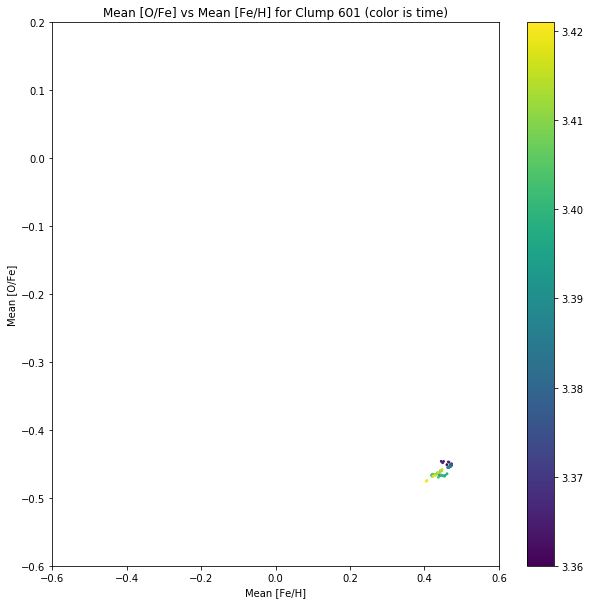

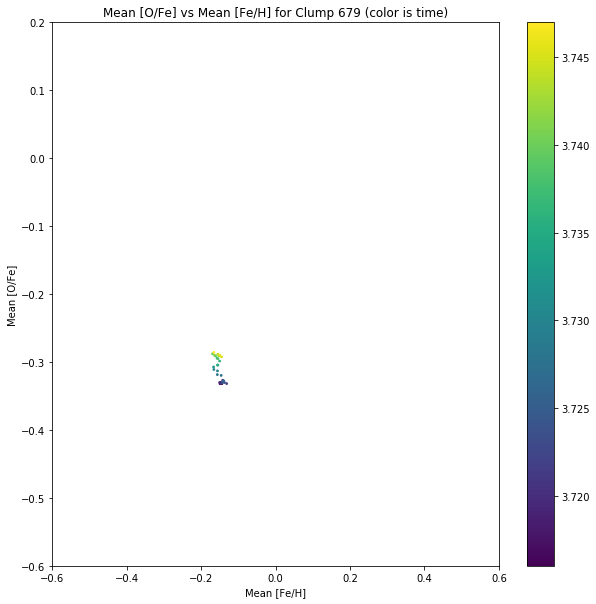

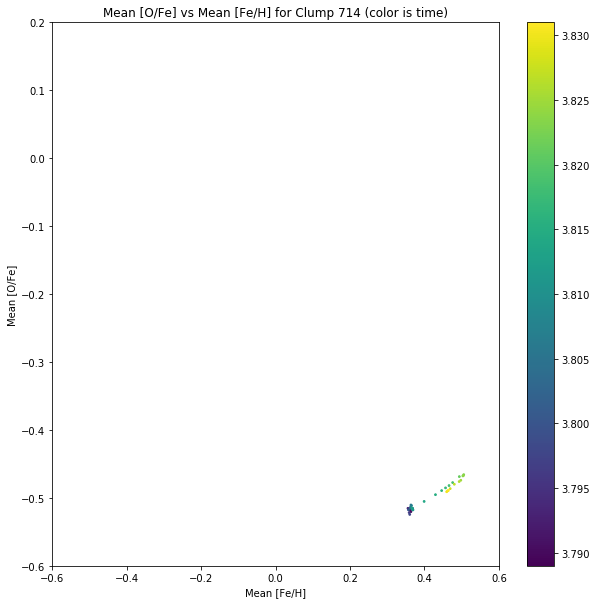

In [18]:
for clumpid in np.unique(np.array(txy['CLUMPID'])):
    plt.figure(figsize=(10,10))
    txyclump = txy[(txy['CLUMPID']==clumpid)]
    plt.scatter(txyclump['MEANFEH'],txyclump['MEANOFE'],c=txyclump['TIME'],s=3)
    plt.colorbar()
    plt.xlabel('Mean [Fe/H]')
    plt.ylabel('Mean [O/Fe]')
    plt.title('Mean [O/Fe] vs Mean [Fe/H] for Clump {} (color is time)'.format(clumpid))
    plt.xlim((-0.6,0.6))
    plt.ylim((-0.6,0.2))

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5,1,'Mean [O/Fe] vs SFR (color is log mass)')

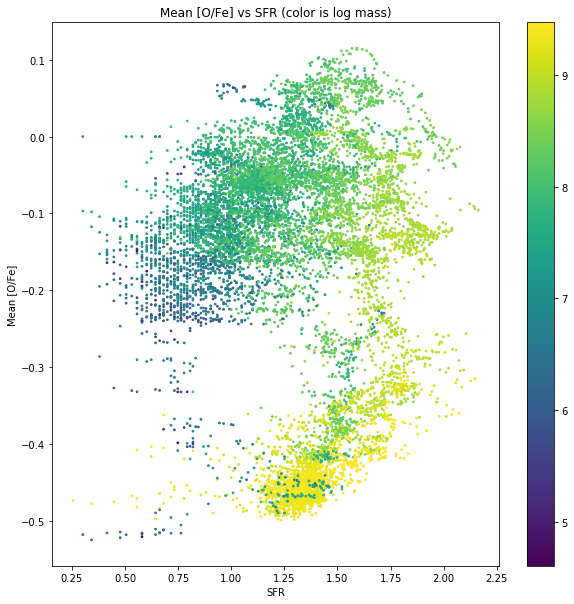

In [27]:
plt.figure(figsize=(10,10))
plt.scatter(np.log10(txy['NSTARS']/5),txy['MEANOFE'],c=np.log10(txy['MASS']),s=3)
plt.colorbar()
plt.xlabel('SFR')
plt.ylabel('Mean [O/Fe]')
plt.title('Mean [O/Fe] vs SFR (color is log mass)')

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5,1,'Mean [Fe/H] vs SFR (color is log mass)')

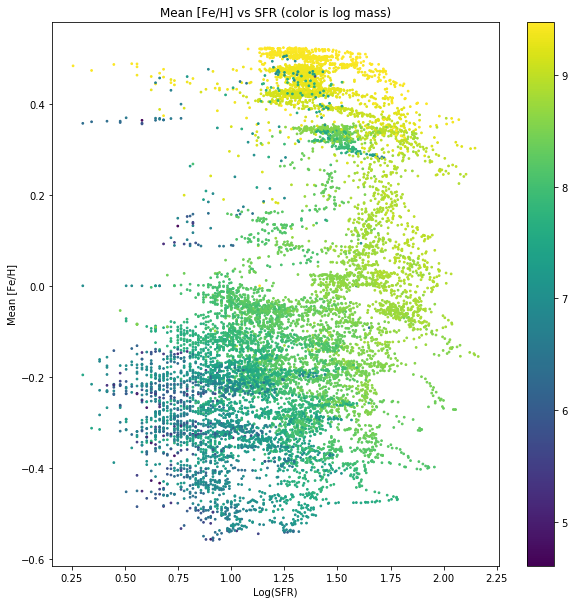

In [37]:
plt.figure(figsize=(10,10))
plt.scatter(np.log10(txy['NSTARS']/5),txy['MEANFEH'],c=np.log10(txy['MASS']),s=3)
plt.colorbar()
plt.xlabel('Log(SFR)')
plt.ylabel('Mean [Fe/H]')
plt.title('Mean [Fe/H] vs SFR (color is log mass)')

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


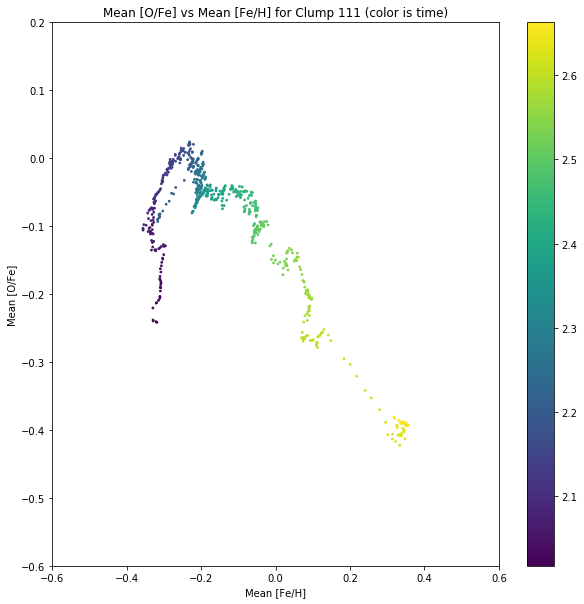

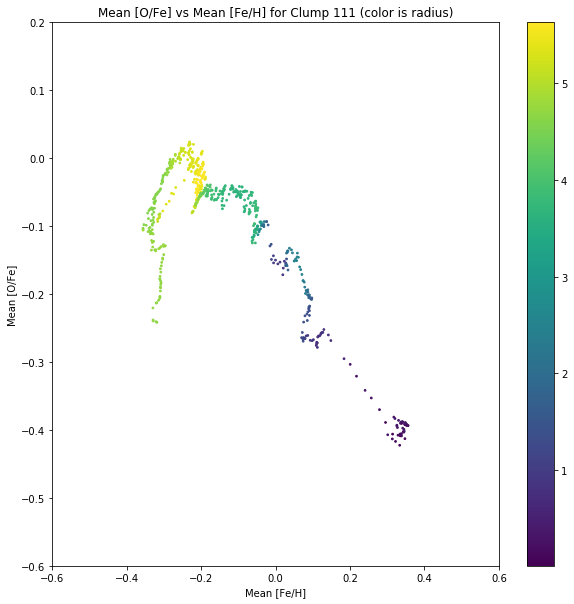

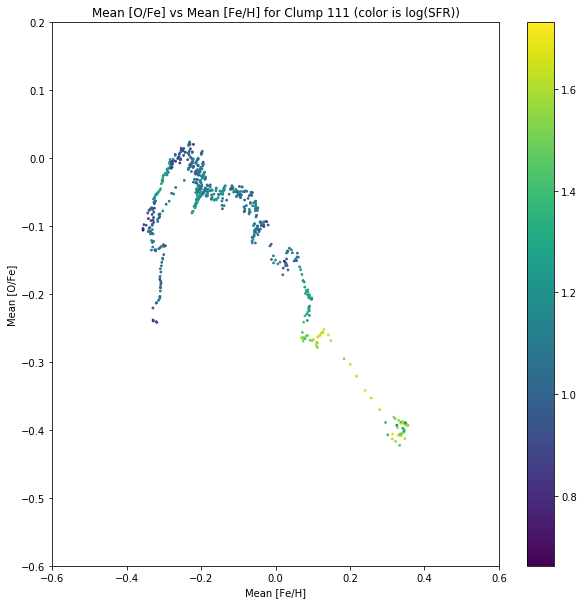

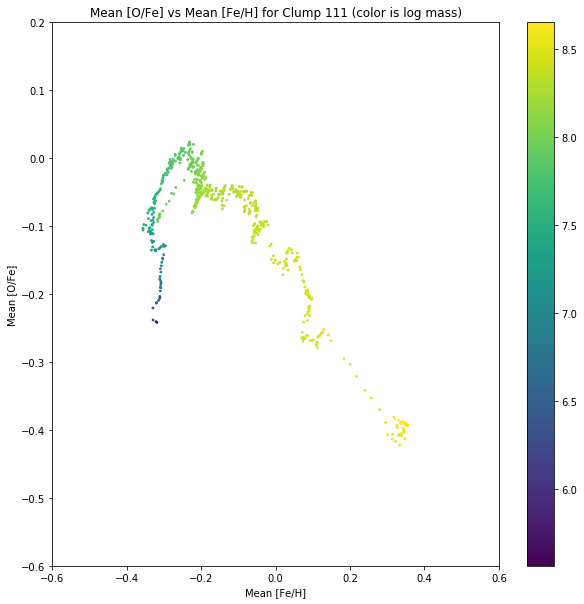

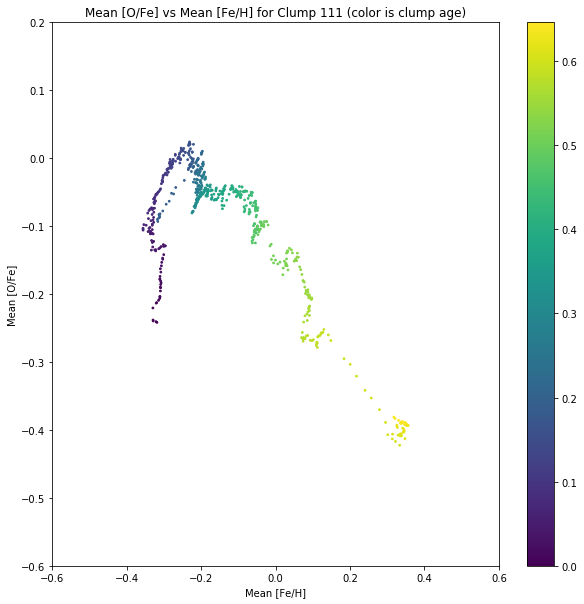

In [38]:
txy111 = txy[(txy['CLUMPID']==111)]
colors = [['time',txy111['TIME']],['radius',(txy111['X']**2+txy111['Y']**2)**(1/2)],
          ['log(SFR)',np.log10(txy111['NSTARS']/5)],['log mass',np.log10(txy111['MASS'])],['clump age',txy111['AGE']]]
for i in colors:
    plt.figure(figsize=(10,10))
    plt.scatter(txy111['MEANFEH'],txy111['MEANOFE'],c=i[1],s=3)
    plt.colorbar()
    plt.xlabel('Mean [Fe/H]')
    plt.ylabel('Mean [O/Fe]')
    plt.title('Mean [O/Fe] vs Mean [Fe/H] for Clump 111 (color is {})'.format(i[0]))
    plt.xlim((-0.6,0.6))
    plt.ylim((-0.6,0.2))

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5,1,'Mean [Fe/H] vs Log Mass (color is SFR)')

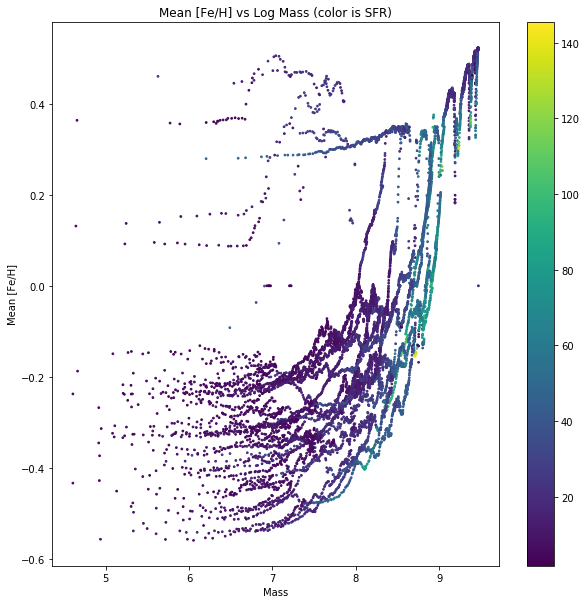

In [36]:
plt.figure(figsize=(10,10))
plt.scatter(np.log10(txy['MASS']),txy['MEANFEH'],c=txy['NSTARS']/5,s=3)
plt.colorbar()
plt.xlabel('Mass')
plt.ylabel('Mean [Fe/H]')
plt.title('Mean [Fe/H] vs Log Mass (color is SFR)')

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5,1,'Mean [O/Fe] vs Log Mass (color is SFR)')

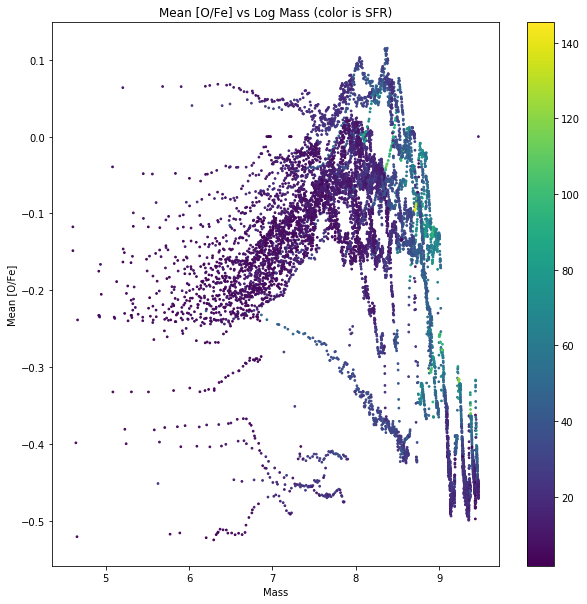

In [34]:
plt.figure(figsize=(10,10))
plt.scatter(np.log10(txy['MASS']),txy['MEANOFE'],c=txy['NSTARS']/5,s=3)
plt.colorbar()
plt.xlabel('Mass')
plt.ylabel('Mean [O/Fe]')
plt.title('Mean [O/Fe] vs Log Mass (color is SFR)')

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5,1,'Log SFR vs Log Mass (color is Mean [Fe/H])')

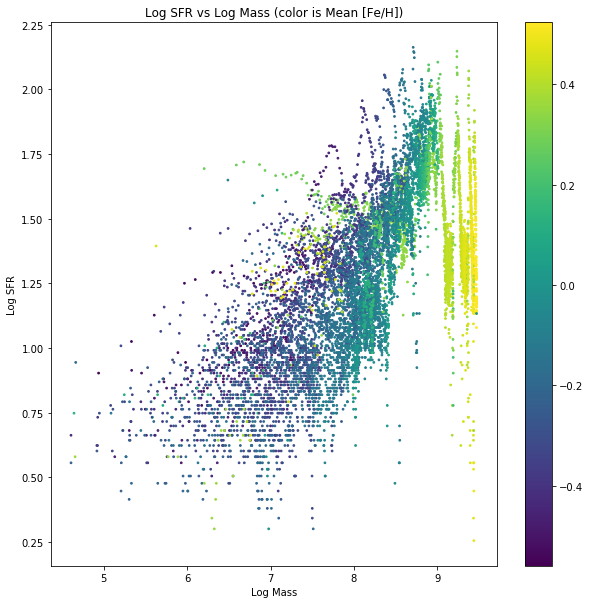

In [8]:
plt.figure(figsize=(10,10))
plt.scatter(np.log10(txy['MASS']),np.log10(txy['NSTARS']/5),c=txy['MEANFEH'],s=3)
plt.colorbar()
plt.xlabel('Log Mass')
plt.ylabel('Log SFR')
plt.title('Log SFR vs Log Mass (color is Mean [Fe/H])')

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5,1,'Log SFR vs Log Mass (color is Mean [O/Fe])')

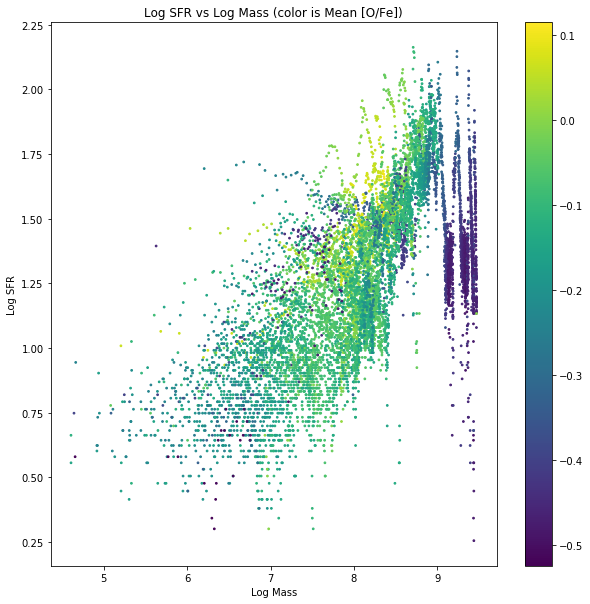

In [9]:
plt.figure(figsize=(10,10))
plt.scatter(np.log10(txy['MASS']),np.log10(txy['NSTARS']/5),c=txy['MEANOFE'],s=3)
plt.colorbar()
plt.xlabel('Log Mass')
plt.ylabel('Log SFR')
plt.title('Log SFR vs Log Mass (color is Mean [O/Fe])')